#### Version's detail (pour qu'on s'y retrouve)
V2 : Able to parse over wiki page info and turn into csv doc. Strugles with special character and disambiguation pages. Citations counts are weird

V2.1 : Solved the special character problem

V2.2 : Cleaned the table and formated the date. Added a little hist to view page creation along time

V2.3 : Adding a function to pass the 500 treshhold in scraping articles title

V2.4 : Adding the scraping of the titles of sub- and sub-sub-sections

In [2]:
!pip install wikipedia setuptools pywikibot mwparserfromhell pandas numpy scipy nltk tqdm seaborn pyqt5 pyqtwebengine ruamel-yaml lxml

In [2]:
import wikipedia
import re
import pywikibot
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.request import urlopen
import json


In [203]:
wikipedia.set_lang("en")  #We make our research in english

#### definition of the function for the CORPUS SELECTION

In [204]:
def function_to_get_all_the_bloody_titles(key_words : str)-> (list[str],int):
    ''' 
    
    '''
    titles = []
    a = key_words.lower().replace(' ', '+')
    scraped_url = 'https://en.wikipedia.org/w/index.php?title=Special:Search&limit=5000&offset=0&profile=default&search={}&ns0=1'.format(a)
    html_text = requests.get(scraped_url).text
    soup = BeautifulSoup(html_text, 'lxml')
    r = soup.find('div', {'class' : 'results-info'})
    nbr_result = int(r.get('data-mw-num-results-total'))
    for interest in soup.find_all('div', {'class' : 'mw-search-result-heading'}):
        titles.append(interest.find('a')['title'])
    return titles, nbr_result

In [205]:
def get_section_titles(page : str) -> list[str]:
    '''
    Returns the section titles

    :param page: Title of the page
    :return: The list of section titles
    '''
    section_tit = set()
    section_title = []
    scraped_url = wikipedia.page(page, auto_suggest = False).url
    html_text = requests.get(scraped_url).text
    soup = BeautifulSoup(html_text, 'lxml')
    r = soup.find_all('h2') + soup.find_all('h3') + soup.find_all('h4')
    for i in r:
        if i.find('span', {'class' : 'mw-headline'}) is not None:
            section_tit.add(i.find('span', {'class' : 'mw-headline'})['id'])
    for i in section_tit:
        section_title.append(i.replace('_', ' '))        
    return section_title

In [5]:
#We define a function to automatically set up a corpus of related articles
def corpus_selection(word_keys : str , number_of_results, key_for_section) -> list[str]:
    '''
    Select the corpus if the keywords are in the section or in the title

    :param word_keys : string 
    
    :return: a dictionnary containing the title of all the pages of the corpus
    '''
    corpus = []
    proper_list = []
    left_list = []
    function = function_to_get_all_the_bloody_titles(word_keys)
    nbr_result = function[1]
    search_list = function[0] #Select and put in a list number_of_results wikipedia articles related to word_keys
    
    for article in tqdm(search_list):
        try:
            wikipedia.summary(article, auto_suggest = False)
            proper_list.append(article)
        except wikipedia.exceptions.DisambiguationError as e:
            pass
        except wikipedia.exceptions.PageError as e:
            try:
                wikipedia.summary(article, auto_suggest = False)
                proper_list.append(article)
            except wikipedia.exceptions.PageError as e:
                pass
    
    for proper_article in tqdm(proper_list):
        if key_for_section in proper_article.lower(): #Among these articles, select the ones whose title contains key_for_selection for the corpus
            corpus.append(proper_article)
        else:
            left_list.append(proper_article) #Put the rest of the articles in a list
            
    for left_article in tqdm(left_list):
        sec_tit = []
        try :
            sec_tit = get_section_titles(left_article)
            for section in sec_tit:
                if key_for_section.lower() in section.lower() and left_article not in corpus:
                    corpus.append(left_article)
        except wikipedia.exceptions.DisambiguationError as e:
            pass
        except wikipedia.exceptions.PageError as e:
            try:
                sec_tit = get_section_titles(left_article)
                for section in sec_tit:
                    if key_for_section.lower() in section.lower() and left_article not in corpus:
                        corpus.append(left_article)
            except wikipedia.exceptions.PageError as e:
                pass

    return corpus[:number_of_results]

## TO LAUNCH THE CORPUS SELECTION

In [7]:
%%time
search_list = corpus_selection("Effects of climate change", 5000, 'climate change')


  1%|▉                                                                               | 57/5000 [00:30<42:35,  1.93it/s]C:\Users\aaugr\anaconda3\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\aaugr\anaconda3\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')
100%|██████████████████████████████████████████████████████████████████████████████| 4776/4776 [46:31<00:00,  1.71it/s]

Wall time: 1h 31min 5s


In [8]:
len(search_list)

921

In [324]:
df = pd.read_csv("climatechange920.csv") 
df.set_index("Unnamed: 0",inplace=True)
search_list=list(df.loc[:,"Name only"])

In [244]:
search_list=["Effects of climate change"]

### Get the information on the protected articles of the corpus

In [214]:
def protection_status(data):
    
    years_off = []
    for i in range(22):
        years_off.append(2001+i)
    
    wrong_ones = []
    dot = pd.DataFrame(years_off)
    
    for article in data:
        
        html_text = requests.get(('https://en.wikipedia.org/wiki/Special:Log?type=protect&user=&page={}&wpdate=&tagfilter=&subtype=').format(article)).text
        soup = BeautifulSoup(html_text, 'lxml')
        dic = {}
        results = soup.find_all('li', {'class' : 'mw-logline-protect'})
        
        for i in results:
            z = i.find('a')
            protection = i.get('data-mw-logaction')
            date = str(z)[str(z).find('Log">') + 5:str(z).find('</a>')]
            dic[pd.to_datetime(date, format = '%H:%M, %d %B %Y')] = protection
        
        if 'expires' in str(results):
            res = str(results).split('span')
            for string in res:
                if '] (expires' in string:
                    date_get = string[string.find('] (expires ') + 11:string.find(' (UTC))')]
                    if ') [' in date_get:
                        date_get = date_get[:date_get.find(') [')]
                    if '] (' in date_get:
                        date_get = date_get[date_get.find(', '):]
                    if ')' in date_get:
                        date_get = date_get.replace(')', '')
                    if date_get[:2] == ', ':
                        date_get = date_get[2:]
                    if date_get[-1] == ' ':
                        date_get = date_get[:-1]
                    if ',' in date_get:
                        date_get = date_get.replace(',', '')
                    try:
                        dic[pd.to_datetime(date_get, format = '%H:%M %d %B %Y')] = 'protect/unprotect'
                    except:
                        try:
                            dic[pd.to_datetime(date_get, format = '%H:%M %B %d %Y')] = 'protect/unprotect'
                        except:
                            wrong_ones.append(article)

        if len(dic) != 0:
            dic = dict(sorted(dic.items()))
            new_dic = {}
            s = set()
            list_date = list(dic.keys())[::-1]
            for date in list_date:
                s.add(date.year)
            for j in sorted(s):
                deadline = pd.to_datetime('30 June {} 00:00:00'.format(j))
                same_year = []
                for date in list_date:
                    if date.year == deadline.year and date <= deadline:
                        same_year.append(date)
                        if len(same_year) != 0:
                            new_dic[deadline.year] = dic[max(same_year)]
                    else :
                        if date.year == deadline.year and date > pd.to_datetime('30 June {}'.format(max(s))):
                            new_dic[max(s) + 1] = dic[max(list_date)]

            keys = list(new_dic.keys())
            for year in years_off:
                if year < min(keys):
                    new_dic[year] = 'protect/unprotect'
                elif year > max(keys):
                    new_dic[year] = new_dic[max(keys)]
                else:
                    for low in keys:
                        for high in keys:
                            if year > low and year < high and len(keys[keys.index(low):keys.index(high)]) == 1:
                                new_dic[year] = new_dic[low]
                                
            d = dict(sorted(new_dic.items()))
            
            if len(d) == 22:
                dot[article] = d.values()
            else:
                dot[article] = list(d.values())[:22]
        
    return dot

In [ ]:
protection_status_evolution = protection_status(search_list)

#### creation of the dataframe

In [325]:
%%time
def crea_dataframe(search_list : list,keyword : str)-> pd.DataFrame:
    '''
    param search_list: liste containing the name of all the articles
    param keyword: string containing the keyword that we want to scrap
    
    
    return: data frame containg the name, the url and the wikicode of the entire page if the keyword is in the title.
    If it's not it returns the wiki code of the section containing the keyword only. Or return the wikicode for each entire page if the line with recode are commented
    '''
    tableau =[] #creation of a list that will contain a dictionnary for each page with the information
    
    
    #this part is if you only want to scrap the citations for the functions
    #It detects if the keyword is included in a section, a subsection or a subsubsection
    #if the aim is to plot only the section then just remove the ''' '''
    '''
    recode= r'(?:==(?:\w|\ )*?(?:'+keyword[0].lower()+'|'+keyword[0].upper()+')'+keyword[1:]+'(?:\w|\ )*?==\n)((?:.|\n)*?)(?:==(?:\w|\ )*==\n)'
    recode2=r'(?:===(?:\w|\ )*?(?:'+keyword[0].lower()+'|'+keyword[0].upper()+')'+keyword[1:]+'(?:\w|\ )*?===\n)((?:.|\n)*?)(?:(?:===|==)(?:\w|\ )*(?:===|==)\n)'
    recode3=r'(?:====(?:\w|\ )*?(?:'+keyword[0].lower()+'|'+keyword[0].upper()+')'+keyword[1:]+'(?:\w|\ )*?====\n)((?:.|\n)*?)(?:(?:===|==|====)(?:\w|\ )*(?:===|==|====)\n)'
    '''
    #browse all the titles  of the search list
    for i in tqdm(range(len(search_list))):
             
        #find the wikipedia page
        page =wikipedia.page(search_list[i], auto_suggest = False)
        page_title =page.title #give the clean name of the page
        page_url=page.url #give the url of the page
        site = pywikibot.Site("en", "wikipedia")
        page = pywikibot.Page(site, page_title)
        
        #if you want to scrap for only the section containing the keywordremove the next line and '''  '''
        page_text=page.text
                
        '''
        if keyword.lower() in page_title.lower(): 
            page_text=page.text
        else:
            page_text = str(re.findall(recode , page.text))
        if page_text=="[]":
            page_text = str(re.findall(recode2, page.text))
        if page_text== "[]":
            page_text = str(re.findall(recode3, page.text))
        '''
            
        infopage ={'Name only' : page_title, 'page url' :page_url,'text':page_text}
        tableau.append(infopage)
    df=pd.DataFrame.from_dict(tableau)
    return df


df=crea_dataframe(search_list,"climate change")
df

100%|████████████████████████████████████████████████████████████████████████████████| 921/921 [09:28<00:00,  1.62it/s]


Wall time: 9min 29s


,Name only,page url,text
0,Effects of climate change,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|Effects created by climate...
1,Effects of climate change on agriculture,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|None}}\n{{about||contribut...
2,Effects of climate change on human health,https://en.wikipedia.org/wiki/Effects_of_clima...,[[File:Atlanta thermal.jpg|thumb|Illustration ...
3,Effects of climate change on oceans,https://en.wikipedia.org/wiki/Effects_of_clima...,{{Short description|Effects of climate change ...
4,Effects of climate change on ecosystems,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|How increased greenhouse g...
...,...,...,...
916,Restore America's Estuaries,https://en.wikipedia.org/wiki/Restore_America%...,{{Infobox organization\n| name = Restore Ameri...
917,Carbon bubble,https://en.wikipedia.org/wiki/Carbon_bubble,{{Short description|Hypothesized bubble in the...
918,The Hunting Hypothesis,https://en.wikipedia.org/wiki/The_Hunting_Hypo...,{{about|the book|the underlying anthropologica...
919,David Quinn (columnist),https://en.wikipedia.org/wiki/David_Quinn_(col...,{{short description|Irish social and religious...


#### definition of the function for the extraction of citation

In [326]:
# Some additional functions
def get_ids_from_ref(ref: str)-> dict:
    '''
    detects if the reference entering this program contains a doi or a pmid or a pmc and if it's the case the return it 
    Also returns the name of the journal in which the article has been published
    
    param ref : the string of a reference
    
    return ids:  a dictionnary containing the doi or pmid or pmc and the journal of the reference if it's a scientific reference
    '''
    
    d = dict(re.findall(r'(doi|pmc|pmid)(?:(?:\s?[=\|]\s?)|(?:\.)|(?:(?:])*?:)|(?:\s|\/)|(?: *=))([^|\s}]*)', ref))
    if d!={}:
        recode=re.findall(r'(?:journal|publisher) *?=((?:\w| |\[|-|\.)*)',ref) +re.findall(r',?(?P<journal>(\s(\w+))+), (V|v)ol',ref) 
        if recode!= []:
            d["journal"]= recode
        else:
            print("beg ref", ref,"end")
    ids = {k: v for k, v in d.items() if v}    
    return ids

        
def get_citations(wikicode : str)-> dict:
    '''
    param  wikicode: a string containing the wikicode of the page or section of which we want to extract the code
    
    return a dictionnary containing all the information about the citation we want to extract
    '''
    #detection of the citations in the wikicode
    citations = [c.lower() for c in re.findall(r'<ref(?:\s(?:[^\/]*?))?>(.*?)<\/ref>', wikicode) + re.findall(r'({{(?:cite|vcite2|Cite)\s[^}]*}})', wikicode)]
    s = set()
    
    i=0
    for c in citations:
        i+=1
        s.update(c.split('<br/>'))
        
    #Creation of a dataframe containing the citation    
    ds = pd.DataFrame(s, columns=['ref'])
    
   
    ds['ids'] = ds['ref'].apply(get_ids_from_ref)
    ds['pmid'] = ds['ids'].apply(lambda x: x.get('pmid', None))
    ds['doi'] = ds['ids'].apply(lambda x: x.get('doi', None))
    ds['pmc'] = ds['ids'].apply(lambda x: x.get('pmc', None))
    ds["journal"]=ds['ids'].apply(lambda x: x.get('journal', None))
    ds["available"]=ds["ids"]== {}
    
    
    dsbis= ds[(~ds['pmid'].isnull())|~(ds['doi'].isnull())|~(ds['pmc'].isnull())]
    
    ds = ds[(~ds['pmid'].duplicated()) | (ds['pmid'].isnull())]
    ds = ds[(~ds['doi'].duplicated()) | (ds['doi'].isnull())]
    ds = ds[(~ds['pmc'].duplicated()) | (ds['pmc'].isnull())]


    dg=ds.loc[ds["available"]==True,["ref"]]
    dg['ids']=dg['ref'].apply(get_IPCC_guardian_ipbes_from_ref)
    dg['IPCC'] = dg['ids'].apply(lambda x: x.get('IPCC', None))
    dg['ipbes'] = dg['ids'].apply(lambda x: x.get('ipbes', None))
    dg['guard'] = dg['ids'].apply(lambda x: x.get('guardian', None))
    dg["available"]= dg["ids"]=={}
    
    
    dcit=dg.loc[dg["available"]==True,["ref"]]
    dcit['ids'] = dcit['ref'].apply(get_cit_from_ref)
    dcit['org'] = dcit['ids'].apply(lambda x: x.get('org', None))
    dcit['gov'] = dcit['ids'].apply(lambda x: x.get('gov', None))
    dcit['com'] = dcit['ids'].apply(lambda x: x.get('com', None))
    dcit['ncbi'] = dcit['ids'].apply(lambda x: x.get('ncbi.nlm.nih.gov', None))
    dcit["available"]= dcit["ids"]=={}
    
    #creation of a data frame with all the other type of citation that weren't extracted
    drest = dcit.loc[dcit["available"]==True,["ref"]]
    
    dsbis=ds[(~ds['journal'].isnull())]
    dgbisgov=dcit[(~dcit['gov'].isnull())]    
    dgbisorg=dcit[(~dcit['org'].isnull())]
    dgbisIPCC=dg[(~dg['IPCC'].isnull())]    
    dgbiscom=dcit[(~dcit['com'].isnull())]
    dgbisncbi=dcit[(~dcit['ncbi'].isnull())]
    
    dic = {'Ref count': ds.shape[0],
           'journal_count': dsbis.shape[0]+ dcit[(~dcit['ncbi'].isnull())].shape[0],
           'nb_journal_citations': (dcit[(~dcit['ncbi'].isnull())]).shape[0]+ds[(~ds['pmid'].isnull()) | (~ds['doi'].isnull()) | (~ds['pmc'].isnull())].shape[0],
           "citationjournal":list(list(dsbis["doi"])+list(dsbis["pmid"])+list(dsbis["pmc"])+list(dgbisncbi["ncbi"])),
           "citations.org": dcit[(~dcit['org'].isnull())].shape[0],
           "citations.gov": dcit[(~dcit['gov'].isnull())].shape[0],
           "citationgovtext":list(dgbisgov['gov']),
           "citationorgtext":list(dgbisorg['org']),
           "citationsIPCC.ch": dg[(~dg['IPCC'].isnull())].shape[0],
           "citationautre":drest["ref"].shape[0],
           "citationcomtext":list(dgbiscom['com']),
           "journal":list(dsbis['journal'])+list(dgbisncbi["ncbi"]),
           "citations.com": dcit[(~dcit['com'].isnull())].shape[0],
           "citationsipbes": dg[(~dg['ipbes'].isnull())].shape[0],
           "citationguardian": dg[(~dg['guard'].isnull())].shape[0]}
    
    return dic

In [327]:
def get_cit_from_ref(ref: str)-> dict:
    '''
    detects if the reference entering this program contains a.org, .gov or .com citation except if it's a guardian citation
    
    param ref : the string of a citation
    
    return ids:  a dictionnary containing as keys org, gov and com and in values the name of the site of the citation
    '''
    d = dict(re.findall(r"((?:[(?:\.)(?:\-)\w]*)\.(org|com|gov))", ref, flags=re.IGNORECASE))
    
    #remove the archive because we don't want to count them in the number of .org citation
    if 'archive.org' in d :
        d.pop('archive.org', None)
    if "web.archive.org" in d:
        d.pop('web.archive.org', None)
    if "www.webcitation.org" in d:
        d.pop('www.webcitation.org', None)
    if "ghostarchive.org" in d:
        d.pop("ghostarchive.org", None)
    if "www.ncbi.nlm.nih.gov" in d or "ncbi.nlm.nih.gov" in d:
        d.pop("www.ncbi.nlm.nih.gov", None)
        d.pop("ncbi.nlm.nih.gov",None)
        d["ncbi"]="ncbi.nlm.nih.gov"
        
        
    ids = {v: k for k, v in d.items() if v}
    
    return ids

In [328]:
def get_IPCC_guardian_ipbes_from_ref(ref: str) -> dict:
    '''
    detects if the reference entering this program is an IPCC, ipbes or guardian citation
    
    param ref : the string of a citation
    
    return :  a dictionnary containing as keys guardian, ipbes and IPCC and in values the name of the citation extracted
    '''
    g={}
    citation=list(set(re.findall(r"(ipcc|ipbes|guardian)", ref, flags=re.IGNORECASE)))
    if citation !=None and citation !=[]:
        if "ipcc" in citation:
            g["IPCC"]=citation
        if "ipbes" in citation:
            g["ipbes"]=citation
        if "guardian" in citation:
            g["guardian"]=citation
        return g
    else:
        return{}

## Get the citations

In [329]:
print('Getting citations')
df['citations'] = df['text'].progress_apply(lambda x: get_citations(x))

print("getting the number of references")
df['Ref count'] = df['citations'].progress_apply(lambda x: x['Ref count'])

print("getting the number of scientific citations")
df['nb_journal_citations'] = df['citations'].progress_apply(lambda x: x['nb_journal_citations'])
df["journalcitation"] = df['citations'].progress_apply(lambda x: x['citationjournal'])
df["journal"] = df['citations'].progress_apply(lambda x: x['journal'])
df["nbjournaldetected"]=df['citations'].progress_apply(lambda x: x['journal_count'])

print("getting the number of .org citation")
df["citation org"]=df['citations'].progress_apply(lambda x: x['citations.org'])
df["citationorgtext"]=df['citations'].progress_apply(lambda x: x["citationorgtext"])

print("getting the number of .gov citation")
df["citation gov"]=df['citations'].progress_apply(lambda x: x["citations.gov"])
df["citationgovtext"]=df['citations'].progress_apply(lambda x: x["citationgovtext"])

print("getting the number of IPCC citation")
df["citation IPCC"]=df['citations'].progress_apply(lambda x: x["citationsIPCC.ch"])

print("getting the .com citations")
df["citation com"]=df['citations'].progress_apply(lambda x: x["citations.com"])
df["citationcomtext"]=df['citations'].progress_apply(lambda x: x["citationcomtext"])

print("getting the ipbes citation")
df["citationipbes"]=df['citations'].progress_apply(lambda x: x["citationsipbes"])

print("getting the guardian citation")
df["citationguardian"]=df['citations'].progress_apply(lambda x: x["citationguardian"])

print("getting the other citation")
df["citationautre"]=df['citations'].progress_apply(lambda x: x["citationautre"])

df["citationtext_total"]=df["citationgovtext"]+df["citationcomtext"]+df["citationorgtext"]+df["journal"]

df["org count"]=df["citation org"]/df["Ref count"]
df["gov count"]=df["citation gov"]/df["Ref count"]
df["com count"]=df["citation com"]/df["Ref count"]
df["Sci count"]=df['nb_journal_citations']/df['Ref count']
df['IPCC count']=df['citation IPCC']/df['Ref count']
df['percentage of official sources']=(df['nb_journal_citations']+ df['citation gov']+ df['citation org']+df['citation IPCC']+df['citationipbes'])/df['Ref count']


print('Done!')
df.head()

Getting citations


  0%|                                                                                          | 0/921 [00:00<?, ?it/s]

beg ref world scientists' warning of a climate emergency, william j ripple, christopher wolf, thomas m newsome, phoebe barnard, william r moomaw.  bioscience, biz088, https://doi.org/10.1093/biosci/biz088.  a correction has been published: [https://academic.oup.com/bioscience/advance-article/doi/10.1093/biosci/biz152/5670749 bioscience, biz152] {{webarchive|url=https://web.archive.org/web/20200107153148/https://academic.oup.com/bioscience/advance-article/doi/10.1093/biosci/biz152/5670749 |date=7 january 2020 }}, https://doi.org/10.1093/biosci/biz152 {{webarchive|url=https://web.archive.org/web/20200228183547/https://doi.org/10.1093/biosci/biz088. |date=28 february 2020 }} end
beg ref dr. frauke urban and dr. tom mitchell 2011. [https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.825.4966&rep=rep1&type=pdf climate change, disasters and electricity generation] {{webarchive|url=https://web.archive.org/web/20120920024704/http://www.odi.org.uk/resources/details.asp?id=5792&title=clima

  0%|▎                                                                                 | 4/921 [00:00<01:34,  9.67it/s]

beg ref fraga, h., santos, j.a., malheiro, a.c., oliveira, a.a., moutinho-pereira, j. and jones, g.v., 2015. climatic suitability of portuguese grapevine varieties and climate change adaptation. int. j. clim.: doi:10.1002/joc.4325. end
beg ref fraga, h., garcia de c. a. i., malheiro, a.c., santos, j.a., 2016. modelling climate change impacts on viticultural yield, phenology and stress conditions in europe. global change biology: doi:10.1111/gcb.13382. end
beg ref ferguson, s.h., young, b.g., yurkowski, d.j., anderson, r., willing, c., nielsen, o., 2017. demographic, ecological, and physiological responses of ringed seals to an abrupt decline in sea ice availability. ''peerj'', 5: e2957 [https://doi.org/10.7717/peerj.2957] end
beg ref {{cite journal |title=climate change impacts on harmful algal blooms in u.s. freshwaters: a screening-level assessment |url=http://dx.doi.org/10.1021/acs.est.7b01498.s001 |doi=10.1021/acs.est.7b01498.s001 |access-date=2021-04-12 |website=dx.doi.org}} end
b

  1%|▊                                                                                 | 9/921 [00:00<01:06, 13.76it/s]

beg ref {{cite book
 |title=macroeconomic and financial policies for climate change mitigation: a review of the literature
 |url=https://www.elibrary.imf.org/doc/imf001/28337-9781513511955/28337-9781513511955/other_formats/source_pdf/28337-9781513512938.pdf
 |isbn=978-1-5135-1195-5
 |last1=krogstrup |first1=signe
 |last2=oman |first2=william
 |series=imf working papers
 |date=4 september 2019
|doi=10.5089/9781513511955.001
 |s2cid=203245445
 |issn=1018-5941
}} end
beg ref {{cite web |title=access electronic resources |url=https://www.library.yorku.ca/ezproxy/?qurl=https%3a%2f%2fdoi.org%2f10.1007%2fs43538-021-00034-5 |access-date=2022-04-01 |website=www.library.yorku.ca |doi=10.1007/s43538-021-00034-5}} end
beg ref lough, j. m. (2007), "tropical river flow and rainfall reconstructions from coral luminescence: great barrier reef, australia", ''paleoceanography'', 22, pa2218, {{doi|10.1029/2006pa001377}}. end


  2%|█▏                                                                               | 14/921 [00:00<00:51, 17.48it/s]

beg ref prowse, m., & scott, l. (2008). assets and adaptation: an emerging debate. ids bulletin, 39(4), 42-52.http://onlinelibrary.wiley.com/doi/10.1111/j.1759-5436.2008.tb00475.x/pdf end
beg ref {{cite book|url=http://www.nap.edu/openbook.php?record_id=10850&page=16|title=understanding climate change feedbacks|first=national research|last=council|date=2 december 2003|website=nap.edu|doi=10.17226/10850|isbn=9780309090728}} end


  2%|█▌                                                                               | 18/921 [00:01<00:51, 17.51it/s]

beg ref [http://pubs.aeaweb.org/doi/pdfplus/10.1257/jep.29.1.217 tol correction] end
beg ref {{citation |title=youth files climate case with india's environmental court|doi=10.1163/9789004322714_cclc_2017-0228-011}}. end
beg ref {{cite journal|title=hii|url=http://dx.doi.org/10.5270/esa-121j002|access-date=2021-11-18|website=hii|doi=10.5270/esa-121j002}} end
beg ref {{cite journal|last1=youds|first1=l.|last2=parker|first2=d. j.|last3=adefisan|first3=e. a.|last4=antwi-agyei|first4=p.|last5=bain|first5=c. l.|last6=black|first6=e. c. l.|last7=blyth|first7=a. m.|last8=dougill|first8=a. j.|last9=hirons|first9=l. c.|date=2021-05-13|title=gcrf african swift white paper policy brief: the future of african weather forecasting|url=http://eprints.whiterose.ac.uk/174093/|access-date=2021-05-13|website=eprints.whiterose.ac.uk|language=en|doi=10.5518/100/67}} end
beg ref {{citation |title=analysis of human rights language in the cancun agreements unfccc 16th session of the conference of the parties|

  2%|█▉                                                                               | 22/921 [00:01<00:55, 16.20it/s]

beg ref {{cite journal|last1=evans|first1=j.|last2=karvonen|first2=andrew|date=2011|title=living laboratories for sustainability: exploring the politics and epistemology of urban transition|url=https://www.semanticscholar.org/paper/living-laboratories-for-sustainability:-exploring-evans-karvonen/70cc03ca4a38ab20ef8bab71067f845f0971258b|doi=10.4324/9780203839249-17|doi-broken-date=28 february 2022|s2cid=149370050}} end
beg ref {{cite journal| last1=bazaz| first1=amir| last2=bertoldi| first2=paolo| last3=buckeridge| first3=marcos| last4=cartwright| first4=anton| last5=de coninck| first5=heleen| last6=engelbrecht| first6=francois| last7=jacob| first7=daniela| last8=hourcade| first8=jean-charles| last9=klaus| first9=ian| last10=de kleijne| first10=kiane| last11=lwasa| first11=shauib| last12=markgraf| first12=claire| last13=newman| first13=peter| last14=revi| first14=aromar| last15=rogelj| first15=joeri| last16=schultz| first16=seth| last17=shindell| first17=drew| last18=singh| first18=chan

  3%|██▎                                                                              | 27/921 [00:01<00:51, 17.33it/s]

beg ref translating a global issue into local priority: china’s local government response to climate change   qi, y., ma, l., zhang, h., & li, h. (2008). translating a global issue into local priority: china’s local government response to climate change. the journal of environment & development, 17(4), 379–400. https://doi.org/10.1177/1070496508326123 end
beg ref the lancet, et al., (2020). climate and covid-19: converging crises. the lancet, doi: https://doi.org/10.1016/s0140-6736(20)32579-4 end
beg ref {{cite journal|last=hill|first=christopher|date=2015-06-15|title=abrupt climate change and the atlantic meridional overturning circulation: sensitivity and non-linear response to arctic/sub-arctic freshwater pulses. collaborative research. final report|doi=10.2172/1184378|osti=1184378|url=http://dx.doi.org/10.2172/1184378}} end
beg ref {{cite journal|last=wu|first=qiang|date=2019-12-24|title=satellite observations of unprecedented phytoplankton blooms in the southern ocean|url=http://d

  4%|██▉                                                                              | 33/921 [00:02<00:46, 19.11it/s]

beg ref {{cite journal |title=kernenergie und klima |date=16 october 2021 |doi=10.5281/zenodo.5573718 |url=https://doi.org/10.5281%2fzenodo.5573718|last1=wealer |first1=ben |last2=breyer |first2=christian |last3=hennicke |first3=peter |last4=hirsch |first4=helmut |last5=von hirschhausen |first5=christian |last6=klafka |first6=peter |last7=kromp-kolb |first7=helga |last8=präger |first8=fabian |last9=steigerwald |first9=björn |last10=traber |first10=thure |last11=baumann |first11=franz |last12=herold |first12=anke |last13=kemfert |first13=claudia |last14=kromp |first14=wolfgang |last15=liebert |first15=wolfgang |last16=müschen |first16=klaus }} end
beg ref harenda k.m., lamentowicz m., samson m., chojnicki b.h. (2018) the role of peatlands and their carbon storage function in the context of climate change. in: zielinski t., sagan i., surosz w. (eds) interdisciplinary approaches for sustainable development goals. geoplanet: earth and planetary sciences. springer, cham. https://doi.org/10.

  4%|███▏                                                                             | 36/921 [00:02<00:44, 19.95it/s]

beg ref {{cite book|date=2018|editor-last=islam|editor-first=md. nazrul|editor2-last=van amstel|editor2-first=andré|title=bangladesh i: climate change impacts, mitigation and adaptation in developing countries|url=https://link.springer.com/book/10.1007/978-3-319-26357-1|series=springer climate|language=en-gb|doi=10.1007/978-3-319-26357-1|isbn=978-3-319-26355-7|issn=2352-0698|s2cid=199493022}} end
beg ref {{cite book |last=manley |first=julian |url=http://dx.doi.org/10.1007/978-3-319-92555-4 |title=social dreaming, associative thinking and intensities of affect |date=2018 |isbn=978-3-319-92554-7 |doi=10.1007/978-3-319-92555-4}} end
beg ref {{cite book |last=doppelt |first=bob |url=http://dx.doi.org/10.4324/9781351283885 |title=transformational resilience |date=2017-09-08 |isbn=9781351283885 |doi=10.4324/9781351283885}} end
beg ref {{cite journal|date=2017-11-17|title=air and climate: greenhouse gas emissions by source (edition 2019)|url=http://dx.doi.org/10.1787/ff19698d-en|access-date=

  5%|████                                                                             | 46/921 [00:02<00:37, 23.06it/s]

beg ref {{cite book |author1=shwom, rachael |author2=mccright, aaron |author3=brechin, steven |author4=dunlap, riley |author5=marquart-pyatt, sandra |author6=hamilton, lawrence |date=october 2015|title=climate change and society |chapter=public opinion on climate change |doi=10.1093/acprof:oso/9780199356102.003.0009 |chapter-url=https://www.researchgate.net/publication/299916358 |access-date=2021-06-15 |pages=269–299}} end
beg ref [[michael oppenheimer]] et al., the limits of consensus, in science magazine's state of the planet 2008-2009: with a special section on energy and sustainability, donald kennedy, island press, 1 december 2008, separate as climate change, the limits of consensus [[michael oppenheimer]], brian c. o'neill, mort webster, shardul agrawal, in science 14 september 2007: vol. 317 no. 5844 pp. 1505-1506 doi: 10.1126/science.1144831 end
beg ref [https://web.archive.org/web/20130907043112/http://csi.sagepub.com/content/58/6/897.abstract climate change: what role for soc

  6%|████▌                                                                            | 52/921 [00:02<00:38, 22.69it/s]

beg ref {{cite report |title=macroeconomic and financial policies for climate change mitigation: a review of the literature
 |url=https://www.elibrary.imf.org/doc/imf001/28337-9781513511955/28337-9781513511955/other_formats/source_pdf/28337-9781513512938.pdf |isbn=978-1-5135-1195-5 |last1=krogstrup   |first1=signe |last2=oman        |first2=william |series=imf working papers |date=4 september 2019 |doi=10.5089/9781513511955.001 |s2cid=203245445 |issn=1018-5941|doi-access=free }} end
beg ref {{cite web|title=children and the health burdens of climate change|url=https://www-nejm-org.offcampus.lib.washington.edu/doi/10.1056/nejmp1905504|url-status=live}} end
beg ref {{cite web|title=children and the health burdens of climate change|url=https://www-nejm-org.offcampus.lib.washington.edu/doi/10.1056/nejmp1905504|url-status=live|access-date=15 december 2021|website=washington.edu}} end


  6%|█████                                                                            | 58/921 [00:03<00:37, 23.27it/s]

beg ref terry, geraldine. [http://www.tandfonline.com/doi/abs/10.1080/13552070802696839 "no climate justice without gender justice: an overview of the issues."] ''gender & development'' 17.1 (2009): 5–18. web.(accessed 23 october 2014). end
beg ref boyd, emily. [https://archive.today/20141027174654/http://practicalaction.metapress.com/content/j61l8q/?genre=issue&id=doi:10.3362/9781780440088 "the noel kempff project in bolivia: gender, power, and decision-making in climate mitigation."] ''climate change and gender justice. ed. geraldine terry and caroline sweetman.'' warwickshire: practical action publishing, oxfam gb, 2009. 101–110. web.(accessed 24 october 2014). end
beg ref macgregor, sherilyn. "a stranger silence still: the need for feminist social research on climate change." ''the sociological review'' 57 (2010): 124–140. {{doi|10.1111/j.1467-954x.2010.01889.x}}. end
beg ref demetriades, justina, and emily esplen. "the gender dimensions of poverty and climate change adaptation." '

  7%|█████▋                                                                           | 65/921 [00:03<00:34, 24.76it/s]

beg ref {{cite book|doi = 10.1016/bs.apar.2018.02.001|title = climate change and the neglected tropical diseases|series = advances in parasitology|year = 2018|last1 = booth|first1 = mark|volume = 100|pages = 39–126|pmid = 29753342|pmc = 7103135|isbn = 9780128151693}} end
beg ref {{cite journal|last=usgcrp|editor1-first=d.j|editor1-last=wuebbles|editor2-first=d.w|editor2-last=fahey|editor3-first=k.a|editor3-last=hibbard|editor4-first=d.j|editor4-last=dokken|editor5-first=b.c|editor5-last=stewart|editor6-first=t.k|editor6-last=maycock|title=climate science special report|url=https://science2017.globalchange.gov/|access-date=2021-04-10|website=science2017.globalchange.gov|year=2017|language=en|doi=10.7930/j0j964j6}} end
beg ref [http://pus.sagepub.com/content/9/3/297.short knowledge, ignorance and the popular culture: climate change versus the ozone hole, by sheldon ungar, doi: 10.1088/0963-6625/9/3/306 public understanding of science july 2000 vol. 9 no. 3 297-312] {{webarchive|url=https

  8%|██████▊                                                                          | 78/921 [00:03<00:35, 23.51it/s]

beg ref {{cite book |author1=national research council |author-link=national research council (united states) |title=abrupt impacts of climate change |date=2013 |url=http://www.nap.edu/read/18373/|doi=10.17226/18373 |isbn=978-0-309-28773-9 }} end


  9%|███████▋                                                                         | 87/921 [00:04<00:35, 23.66it/s]

beg ref {{cite journal |last1=shaheen|first1=susan|last2=cohen|first2=adam|last3=bayen|first3=alexandre|date=2018-10-22|title=the benefits of carpooling|url=https://escholarship.org/uc/item/7jx6z631#main|language=en|doi=10.7922/g2dz06gf}} end


 11%|████████▋                                                                       | 100/921 [00:04<00:25, 32.39it/s]

beg ref wolken, j. m., et al. 2011. "evidence and implications of recent and projected climate change in alaska's forest ecosystems". ''ecosphere'' 2(11):124. {{doi|10.1890/es11-00288.1}} end
beg ref wang et al. 2014 http://journals.ametsoc.org/doi/abs/10.1175/jcli-d-12-00800.1 {{webarchive|url=https://web.archive.org/web/20150330053659/http://journals.ametsoc.org/doi/abs/10.1175/jcli-d-12-00800.1 |date=2015-03-30 }} end


 12%|█████████▍                                                                      | 108/921 [00:04<00:27, 29.70it/s]

beg ref guivarch, celine and hallegatte, s., 2c or not 2c? 19 january 2012. feem working paper no. 87.2011. {{doi|10.2139/ssrn.1988201}} end


 14%|██████████▉                                                                     | 126/921 [00:05<00:27, 29.42it/s]

beg ref etheridge, d. m.; l. p. steele, r. l. langenfelds, r. j. francey, j.-m. barnola, v. i. morgan (1996) "[http://adsabs.harvard.edu/abs/1996jgr...101.4115e bibcode 1996jgr...101.4115e. natural and anthropogenic changes in atmospheric co2 over the last 1000 years from air in antarctic ice and firn]". [[journal of geophysical research]] 101 (d2): 4115–4128. {{doi|10.1029/95jd03410}} {{issn|0148-0227}} end


 14%|███████████▌                                                                    | 133/921 [00:05<00:30, 25.67it/s]

beg ref diaz-ambrona, carlos g.h.; gigena, ruben; mendoza, carlos onan (2013-05-08). "climate change impacts on maize and dry bean yields of smallholder farmers in honduras". revista iberoamericana de estudios de desarrollo = iberoamerican journal of development studies. 2 (1): 4–22. doi:10.26754/ojs_ried/ijds.43. issn 2254-2035. end
beg ref mcmahan, caleb d.; fuentes-montejo, césar e.; ginger, luke; carrasco, juan carlos; chakrabarty, prosanta; matamoros, wilfredo a. (2020-07-29). "climate change models predict decreases in the range of a microendemic freshwater fish in honduras". scientific reports. 10 (1): 12693. doi:10.1038/s41598-020-69579-7. issn 2045-2322. end
beg ref bradatan, cristina; dennis, jeffrey a.; flores-yeffal, nadia; swain, sharmistha (2020-01-28). "child health, household environment, temperature and rainfall anomalies in honduras: a socio-climate data linked analysis". environmental health. 19 (1): 10. doi:10.1186/s12940-020-0560-9. issn 1476-069x. pmc 6986158. {{p

 15%|████████████▏                                                                   | 140/921 [00:06<00:27, 28.15it/s]

beg ref overland, indra; sagbakken, haakon fossum; chan, hoy-yen; merdekawati, monika; suryadi, beni; utama, nuki agya; vakulchuk, roman (2021). the asean climate and energy paradox. ''energy and climate change''. '''2''': 100019. <nowiki>https://doi.org/10.1016/j.egycc.2020.100019</nowiki>   end
beg ref bentz, julia. "learning about climate change in, with and through art". ''climatic change'', vol 162, no. 3, 2020, pp. 1600-1601, 1601-1602. ''springer science and business media llc'', <nowiki>https://doi.org/10.1007/s10584-020-02804-4</nowiki>. accessed 18 nov 2021. end
beg ref sommer, laura kim, and christian andreas klöckner. "does activist art have the capacity to raise awareness in audiences?—a study on climate change art at the artcop21 event in paris.". ''psychology of aesthetics, creativity, and the arts'', vol 15, no. 1, 2021, pp. 61, 62-66, 66-67, 68, 73. ''ebscohost'', <nowiki>http://dx.doi.org.offcampus.lib.washington.edu/10.1037/aca0000247</nowiki>. accessed 18 nov 2021. 

 17%|█████████████▉                                                                  | 160/921 [00:06<00:25, 29.73it/s]

beg ref jacobson, m.z. (2009) [https://web.archive.org/web/20100424234910/http://www.stanford.edu/group/efmh/jacobson/pdf%20files/reviewsolgw09.pdf "review of solutions to global warming, air pollution, and energy security"] ''[[energy and environmental science]]'' '''2''':148-73 [https://dx.doi.org/10.1039/b809990c doi 10.1039/b809990c] (review) end


 20%|████████████████                                                                | 185/921 [00:07<00:20, 35.56it/s]

beg ref {{cite book|date=2018|editor-last=von storch|editor-first=hans|editor2-last=meinke|editor2-first=insa|editor3-last=claußen|editor3-first=martin|title=hamburger klimabericht – wissen über klima, klimawandel und auswirkungen in hamburg und norddeutschland|language=en-gb|doi=10.1007/978-3-662-55379-4|isbn=978-3-662-55378-7}} end
beg ref {{cite book|last=|first=|date=2013|editor-last=intergovernmental panel on climate change|title=climate change 2013 - the physical science basis|url=http://ebooks.cambridge.org/ref/id/cbo9781107415324|language=en|volume=|pages=|doi=10.1017/cbo9781107415324|via=|isbn=9781107415324}} end
beg ref hoekema and sridhar (2011). "relating climatic attributes and water resources allocation: a study using surface water supply and soil moisture indices in the snake river basin, idaho."  water resources research,  vol. 47 wo7536, {{doi| 10.1029/2010/wr009697}} end
beg ref {{cite book|last1=kronik|first1=jakob|last2=verner|first2=dorte|title=indigenous peoples a

 21%|████████████████▊                                                               | 194/921 [00:07<00:19, 36.43it/s]

beg ref elias, e.h.; flynn, r.; idowu, o.j.; reyes, j.; sanogo, s.; schutte, b.j.; smith, r.; steele, c.; sutherland, c. crop vulnerability to weather and climate risk: analysis of interacting systems and adaptation efficacy for sustainable crop production. ''sustainability'' 2019, ''11'', 6619. {{doi|10.3390/su11236619}} end
beg ref persad, g.g., swain, d.l., kouba, c. ''et al.'' inter-model agreement on projected shifts in california hydroclimate characteristics critical to water management. ''climatic change'' 162, 1493–1513 (2020). <nowiki>https://doi.org/10.1007/s10584-020-02882-4</nowiki> end
beg ref carlisle, liz, maywa montenegro de wit, marcia s. delonge, alastair iles, adam calo, christy getz, joanna ory, katherine munden-dixon, ryan galt, brett melone, reggie knox, and daniel press. 2019. "transitioning to sustainable agriculture requires growing and sustaining an ecologically skilled workforce." ''frontiers in sustainable food systems.'' <nowiki>https://doi.org/10.3389/fsuf

 23%|██████████████████▌                                                             | 214/921 [00:08<00:19, 35.51it/s]

beg ref {{cite book|date=2000-10-25|title=ancillary benefits and costs of greenhouse gas mitigation|url=http://dx.doi.org/10.1787/9789264188129-en|doi=10.1787/9789264188129-en|isbn=9789264185425}} end
beg ref huang, y., & bani shahabadi, m. (2014). [https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1002/2014jd022466 why logarithmic? a note on the dependence of radiative forcing on gas concentration]. journal of geophysical research: atmospheres, 119(24), 13-683. end
beg ref myhre, g., highwood, e. j., shine, k. p., & stordal, f. (1998). [https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/98gl01908 new estimates of radiative forcing due to well mixed greenhouse gases]. geophysical research letters, 25(14), 2715-2718. end


 24%|███████████████████▎                                                            | 222/921 [00:08<00:25, 27.79it/s]

beg ref {{cite book|last=isbell|first=william h.|chapter=wari and tiwanaku: international identities in the central andean middle horizon|title=the handbook of south american archaeology |year=2008 |pages=731–751 |doi=10.1007/978-0-387-74907-5_37 |isbn=978-0-387-74906-8}} end
beg ref friedlingstein, p., jones, m., o'sullivan, m., andrew, r., hauck, j., peters, g., peters, w., pongratz, j., sitch, s., le quéré, c. and 66 others (2019) "global carbon budget 2019". ''earth system science data'', '''11'''(4): 1783–1838. {{doi|10.5194/essd-11-1783-2019}}. [[file:cc-by icon.svg|50px]] modified text was copied from this source, which is available under a [https://creativecommons.org/licenses/by/4.0/ creative commons attribution 4.0 international license]. end
beg ref {{cite book |doi = 10.1007/978-3-319-93284-2_5|chapter = phytoplankton responses to marine climate change – an introduction|title = youmares 8 – oceans across boundaries: learning from each other|year = 2018|last1 = käse|first1 =

 25%|████████████████████                                                            | 231/921 [00:08<00:25, 27.17it/s]

beg ref {{cite journal |title=figure 1. the economy has been volatile but also resilient to shocks |url=http://dx.doi.org/10.1787/888933338536 |access-date=2022-03-23 |website=dx.doi.org|doi=10.1787/888933338536 }} end
beg ref poleward shift of the major ocean gyres detected in a warming climate. geophysical research letters, 47, e2019gl085868 {{doi|10.1029/2019gl085868}} end
beg ref grantham-mcgregor, sally et al., the international child development steering group. “developmental potential in the first 5 years for children in developing countries.” lancet 369.9555 (2007): 60–70. pmc. web. 28 nov. 2014. end
beg ref {{cite journal|last=oster|first=emily|date=july 2016|title=does disease cause vaccination? disease outbreaks and vaccination response|url=http://www.nber.org/papers/w22464.pdf|location=cambridge, ma|doi=10.3386/w22464|doi-access=free}} end


 26%|████████████████████▌                                                           | 237/921 [00:09<00:25, 26.33it/s]

beg ref {{cite book |last1=kappelle |first1=m |year=2004 |chapter=tropical montane forests |pages=1782–92 |doi=10.1016/b0-12-145160-7/00175-7 |editor1-first=jeffery |editor1-last=burley |title=encyclopedia of forest sciences |isbn=978-0-12-145160-8 }} end
beg ref {{cite book |last1=hamilton |first1=lawrence s |last2=juvik |first2=james o |last3=scatena |first3=f. n |year=1995 |chapter=the puerto rico tropical cloud forest symposium: introduction and workshop synthesis |pages=1–18 |doi=10.1007/978-1-4612-2500-3_1 |editor1-first=lawrence s. |editor1-last=hamilton |editor2-first=james o. |editor2-last=juvik |editor3-first=f. n. |editor3-last=scatena |title=tropical montane cloud forests |volume=110 |series=ecological studies |isbn=978-1-4612-7564-0 }} end
beg ref {{cite book |last1=bruijnzeel |first1=l. a |last2=proctor |first2=j |year=1995 |chapter=hydrology and biogeochemistry of tropical montane cloud forests: what do we really know? |pages=38–78 |doi=10.1007/978-1-4612-2500-3_3 |edito

 26%|█████████████████████                                                           | 243/921 [00:09<00:26, 25.23it/s]

 {{cite journal|last1=holcomb|first1=m.|last2=cohen|first2=a. l.|last3=mccorkle|first3=d. c.|date=2011-08-23|title=a gender bias in the calcification response to ocean acidification|url=https://bg.copernicus.org/preprints/8/8485/2011/bgd-8-8485-2011.pdf|doi=10.5194/bgd-8-8485-2011|doi-access=free}} end
beg ref vanwonterghem, i. and webster, n.s. (2020) "coral reef microorganisms in a changing climate". ''iscience'', '''23'''(4). {{doi|10.1016/j.isci.2020.100972}}. end
beg ref [[perry miller|miller, perry]] (april 1951). "the end of the world". ''the william and mary quarterly''. '''8''' (2): 172–191. [[digital object identifier|doi]]:10.2307/1916901. [[jstor]] 1916901. end
beg ref {{cite book|title=world food and agriculture – statistical yearbook 2021|url=https://www.fao.org/documents/card/en/c/cb4477en/|url-status=live|access-date=december 10, 2021|website=www.fao.org|year=2021|language=en|doi=10.4060/cb4477en|isbn=978-92-5-134332-6|s2cid=240163091}} end


 27%|█████████████████████▋                                                          | 249/921 [00:09<00:27, 24.23it/s]

beg ref {{cite iucn |author=birdlife international |date=2018 |title=''fratercula arctica'' |volume=2018 |page=e.t22694927a132581443 |doi=10.2305/iucn.uk.2018-2.rlts.t22694927a132581443.en |access-date=19 november 2021}} end
beg ref  pasher, j., seed, e., & duffe, j. (2013). “development of boreal ecosystem anthropogenic disturbance layers for canada based on 2008 to 2010 landsat imagery.” canadian journal of remote sensing, 39(1), 42-58. {{doi|10.5589/m13-007}}  end
beg ref tinner, w., bigler, c., gedye, s., gregory-eaves, i., jones, r. t., kaltenrieder, p., . . . hu, f. s. (2008). a 700-year paleoecological record of boreal ecosystem responses to climatic variation from alaska. ecology, 89(3), 729-743. {{doi|10.1890/06-1420.1}} end
beg ref lal, r. (2004). soil carbon sequestration to mitigate climate change. geoderma, 123(1-2), 1-22. {{doi|10.1016/j.geoderma.2004.01.032}} end
beg ref pohjanmies, t., triviño, m., le tortorec, e. et al. ambio (2017) 46: 743. https://doi.org/10.1007/s13

 28%|██████████████████████▏                                                         | 255/921 [00:09<00:26, 25.48it/s]

beg ref {{cite conference | last=ribas | first=ignasi | conference=proceedings of the iau symposium 264 'solar and stellar variability – impact on earth and planets' | title=the sun and stars as the primary energy input in planetary atmospheres | volume=264 | pages=3–18 |date=february 2010 | doi=10.1017/s1743921309992298 | bibcode=2010iaus..264....3r |arxiv = 0911.4872 }} end
beg ref [http://people.deas.harvard.edu/~vtsai/files/tsaiekstrom_jgr2007.pdf "analysis of glacial earthquakes"] {{webarchive|url=https://web.archive.org/web/20081007050046/http://people.deas.harvard.edu/~vtsai/files/tsaiekstrom_jgr2007.pdf |date=2008-10-07 }} tsai, v. c. and g. ekström (2007). j. geophys. res., 112, f03s22, {{doi|10.1029/2006jf000596}} end
beg ref [http://people.deas.harvard.edu/~vtsai/files/ekstromnettlestsai_science2006.pdf "seasonality and increasing frequency of greenland glacial earthquakes"] {{webarchive|url=https://web.archive.org/web/20081007062935/http://people.deas.harvard.edu/~vtsai/fil

 28%|██████████████████████▋                                                         | 261/921 [00:10<00:26, 25.37it/s]

beg ref cavanaugh, k. c., kellner, j. r., forde, a. j., gruner, d. s., parker, j. d., rodriguez, w., & feller, i. c. (2014). poleward expansion of mangroves is a threshold response to decreased frequency of extreme cold events. proceedings of the national academy of sciences of the united states of america, 111(2), 723–7. doi:10.1073/pnas.1315800111 end
beg ref alongi, d. m. (2008). mangrove forests: resilience, protection from tsunamis, and responses to global climate change. [[estuarine, coastal and shelf science]], 76(1), 1–13. doi:10.1016/j.ecss.2007.08.024 end
beg ref day, j. w., christian, r. r., boesch, d. m., yáñez-arancibia, a., morris, j., twilley, r. r., … stevenson, c. (2008). consequences of climate change on the ecogeomorphology of coastal wetlands. estuaries and coasts, 31(3), 477–491. doi:10.1007/s12237-008-9047-6 end
beg ref church, j. a., & white, n. j. (2006). a 20th century acceleration in global sea-level rise. geophysical research letters, 33(1), n/a–n/a. doi:10.1

 29%|███████████████████████▎                                                        | 269/921 [00:10<00:22, 29.25it/s]

beg ref {{cite book|last=foster|first=john|date=2014-08-07|title=after sustainability|url=http://dx.doi.org/10.4324/9781315888576|doi=10.4324/9781315888576|isbn=9781315888576}} end
beg ref {{cite book|last=orange|first=donna m.|date=2016-09-13|title=climate crisis, psychoanalysis, and radical ethics|url=http://dx.doi.org/10.4324/9781315647906|doi=10.4324/9781315647906|isbn=9781315647906}} end
beg ref taylor s. (2020). anxiety disorders, climate change, and the challenges ahead: introduction to the special issue. journal of anxiety disorders, 76, 102313. https://doi.org/10.1016/j.janxdis.2020.102313 end
beg ref grant l. k. (2011). can we consume our way out of climate change? a call for analysis. ''the behavior analyst'', ''34''(2), 245–266. <nowiki>https://doi.org/10.1007/bf03392256</nowiki> end
beg ref ''observation of swell dissipation across oceans'', f. ardhuin, collard, f., and b. chapron, 2009: geophys. res. lett. 36, l06607, {{doi|10.1029/2008gl037030}} end
beg ref {{cite iucn |

 30%|███████████████████████▉                                                        | 276/921 [00:10<00:22, 28.26it/s]

 {{cite iucn |author=wiig, ø. |author2=amstrup, s. |author3=atwood, t. |author4=laidre, k. |author5=lunn, n. |author6=obbard, m. |author7=regehr, e. |author8=thiemann, g. |date=2015 |title=''ursus maritimus'' |volume=2015 |page=e.t22823a14871490 |doi=10.2305/iucn.uk.2015-4.rlts.t22823a14871490.en |access-date=19 november 2021}} end
beg ref {{cite book |author=office of international affairs |title=lost crops of the incas: little-known plants of the andes with promise for worldwide cultivation |date=1989 |url=http://www.nap.edu/openbook.php?isbn=030904264x&page=92 |work=nap.edu |isbn=978-0-309-04264-2 |page=92|doi=10.17226/1398 }} end
beg ref mla	rowley-conwy, peter, and robert layton. “foraging and farming as niche construction: stable and unstable adaptations.” philosophical transactions of the royal society of london. series b, biological sciences vol. 366,1566 (2011): 849-62. {{doi|10.1098/rstb.2010.0307}} end
beg ref {{cite book |last1=frouz |first1=jan |last2=frouzová |first2=jaro

 31%|████████████████████████▋                                                       | 284/921 [00:10<00:20, 31.35it/s]

beg ref {{cite iucn |author=birdlife international |date=2016 |title=''plectrophenax nivalis'' |volume=2016 |page=e.t22721043a89345729 |doi=10.2305/iucn.uk.2016-3.rlts.t22721043a89345729.en |access-date=12 november 2021}} end
beg ref {{cite book|title=methods for monitoring tiger and prey populations {{!}} springerlink|url=https://link.springer.com/content/pdf/10.1007/978-981-10-5436-5.pdf|doi=10.1007/978-981-10-5436-5|isbn=978-981-10-5435-8|year=2017|s2cid=33402538|editor1-last=karanth|editor1-first=k. ullas|editor2-last=nichols|editor2-first=james d.}} end
beg ref {{cite report |last1=gregory |first1=christian a. |last2=coleman-jensen |first2=alisha |last3=gregory |first3=christian a. |last4=coleman-jensen |first4=alisha |date=2017 |title=food insecurity, chronic disease, and health among working-age adults |website=agecon search |url=https://ageconsearch.umn.edu/record/261813 |language=en |doi=10.22004/ag.econ.261813}} end
beg ref swinnen, johan; and mcdermott, john. 2020. covid-19:

 31%|█████████████████████████                                                       | 288/921 [00:11<00:22, 27.73it/s]

beg ref {{cite book|last1=darrin|first1=ann|title=itherm 2000. the seventh intersociety conference on thermal and thermomechanical phenomena in electronic systems (cat. no.00ch37069)|chapter=variable emissivity through mems technology|year=2000|pages=264–270|chapter-url=https://ieeexplore.ieee.org/document/866834|doi=10.1109/itherm.2000.866834|hdl=2060/20000089965|isbn=0-7803-5912-7|s2cid=109389129|access-date=7 january 2021|quote=specialized thermal control coatings, which can passively or actively adjust their emissivity offer an attractive solution to these [spacecraft] design challenges.|archive-date=24 june 2018|archive-url=https://web.archive.org/web/20180624074852/https://ieeexplore.ieee.org/document/866834/|url-status=live}} end
beg ref van der geest, k. & warner, k. (2019) [https://collections.unu.edu/eserv/unu:7535/vandergeest_warner_2019_climate_policy_ld_ipcc_wg2_ar5_meta.pdf loss and damage in the [[ipcc fifth assessment report]] (working group ii): a text-mining analysis]

 32%|█████████████████████████▌                                                      | 294/921 [00:11<00:24, 25.75it/s]

beg ref {{cite book |last1=movasat |first1=mahta |last2=tomac |first2=ingrid |title=geo-congress 2020 |date=2020-02-21 |chapter=post-fire mudflow prevention by biopolymer treatment of water repellent slopes |chapter-url=https://ascelibrary.org/doi/abs/10.1061/9780784482834.019 |language=en |pages=170–178 |doi=10.1061/9780784482834.019|isbn=9780784482834 |s2cid=213023120 }} end
beg ref {{cite journal|url=https://www.cdc.gov/niosh/docs/2013-158/|title=cdc – niosh publications and products – wildland fire fighting: hot tips to stay safe and healthy (2013–158)|website=www.cdc.gov|access-date=2016-11-22|url-status=live|archive-url=https://web.archive.org/web/20161122154309/http://www.cdc.gov/niosh/docs/2013-158/|archive-date=22 november 2016|doi=10.26616/nioshpub2013158|year=2013}} end
beg ref {{cite journal|url=http://www.ncdc.noaa.gov/billions/docs/smith-and-katz-2013.pdf|title=smith a.b. and r. katz, 2013: u.s. billion-dollar weather and climate disasters: data sources, trends, accuracy,

 33%|██████████████████████████▌                                                     | 306/921 [00:11<00:20, 29.86it/s]

beg ref {{cite magazine |last=seager |first=richard |date=july–august 2006 |title=the source of europe's mild climate |url=https://www.americanscientist.org/article/the-source-of-europes-mild-climate |magazine=[[american scientist]] |volume=94 |issue=4 |page=334 |doi=10.1511/2006.60.334 |postscript=. subhead: "the notion that the gulf stream is responsible for keeping europe anomalously warm turns out to be a myth".}} end
beg ref {{cite journal |title=access electronic resources |url=https://www.library.yorku.ca/ezproxy/?qurl=https%3a%2f%2fdoi.org%2f10.1111%2f1365-2664.13832 |access-date=2022-03-28 |website=www.library.yorku.ca |doi=10.1111/1365-2664.13832|s2cid = 233617330}} end
beg ref {{cite journal |title=access electronic resources |url=https://www.library.yorku.ca/ezproxy/?qurl=https%3a%2f%2fdoi.org%2f10.1017%2fs0030605320000551 |access-date=2022-03-28 |website=www.library.yorku.ca |doi=10.1017/s0030605320000551|s2cid = 245287460}} end
beg ref pang sean e h, de alban jose don t, 

 34%|███████████████████████████▎                                                    | 314/921 [00:11<00:20, 30.31it/s]

beg ref {{cite web |title=global carbon budget 2021 |url=https://essd.copernicus.org/preprints/essd-2021-386/ |website=earth system science data discussions |access-date=19 april 2022 |pages=1–191 |language=english |doi=10.5194/essd-2021-386 |date=4 november 2021}} end
beg ref {{cite book|title=unwto tourism highlights: 2019 edition {{!}} world tourism organization|year=2019|doi=10.18111/9789284421152|isbn=978-92-844-2115-2|s2cid=240665765}} end
beg ref ludwig ellenberg: ''die meerenge von gibraltar – küstenmorphologie zwischen mittelmeer und atlantik.'' in: ''geographica helvetica.'' vol.&nbsp;36, no.&nbsp;3, 1981, pp.&nbsp;109–120, [[doi:10.5194/gh-36-109-1981]] end
beg ref {{cite book |doi=10.1007/b107143 |chapter=circulation in the mediterranean sea |title=the mediterranean sea |volume=5k |pages=29–66 |series=handbook of environmental chemistry |year=2005 |last1=millot |first1=claude |last2=taupier-letage |first2=isabelle |isbn=978-3-540-25018-0 |chapter-url=https://hal.archives-ou

 35%|███████████████████████████▉                                                    | 321/921 [00:12<00:23, 25.39it/s]

beg ref {{cite book |doi=10.1007/978-94-011-5874-9_7 |chapter=how do rare species avoid extinction? a paleontological view |title=the biology of rarity |year=1997 |last1=mckinney |first1=michael l. |pages=110–129 |isbn=978-94-010-6483-5 |editor1-last=kunin |editor1-first=w. e. |editor2-last=gaston |editor2-first=k. j. |chapter-url=https://books.google.com/books?id=4lhncaaaqbaj&pg=pa110 }} end
beg ref {{cite iucn |author=birdlife international |date=2017 |title=''calidris fuscicollis'' |volume=2017 |page=e.t22693399a119296025 |doi=10.2305/iucn.uk.2017-3.rlts.t22693399a119296025.en |access-date=12 november 2021}} end


 36%|████████████████████████████▋                                                   | 330/921 [00:12<00:26, 22.14it/s]

beg ref [https://www.researchgate.net/publication/222296321_the_indian_ocean_coast_of_somalia "the indian ocean coast of somalia"]. ''marine pollution bulletin''. '''41''' (1-6): 141–159. december 2000. doi: 10.1016/s0025-326x(00)00107-7 end
beg ref thorsteinson, l. k., and love, m. s., eds., 2016, alaska arctic marine fish ecology catalog: u.s. geological survey scientific investigations report 2016-5038 (ocs study, boem 2016-048), 768 p., [[doi:10.3133/sir20165038]]. end
beg ref hannah hoag, [http://www.nature.com/nbt/journal/v27/n8/full/nbt0809-690.html#a1 the cold rush], ''[[nature biotechnology]]'' 27, 690–692 (2009), [[doi:10.1038/nbt0809-690]]. end


 37%|█████████████████████████████▍                                                  | 339/921 [00:13<00:25, 22.91it/s]

beg ref {{cite journal|last=frouz|first=jan|last2=frouzová|first2=jaroslava|date=2022|title=applied ecology|url=https://link.springer.com/book/10.1007/978-3-030-83225-4|language=en-gb|doi=10.1007/978-3-030-83225-4}} end


 37%|█████████████████████████████▉                                                  | 345/921 [00:13<00:27, 20.62it/s]

beg ref {{cite journal|last=zappalà|first=guglielmo|date=2018|title=central banks' role in responding to climate change: monetary policy and macroprudential regulation|url=http://rgdoi.net/10.13140/rg.2.2.33035.80167|language=en|doi=10.13140/rg.2.2.33035.80167}} end
beg ref {{cite book| vauthors = holloway sl | veditors = holloway sl, valentine g |date=2004-11-23|title=children's geographies|doi=10.4324/9780203017524|isbn=978-0-203-01752-4 }} end


 38%|██████████████████████████████▍                                                 | 351/921 [00:13<00:26, 21.38it/s]

beg ref bell, karen, “bread and roses: a gender perspective on environmental justice and public health” ''international journal of environmental research and public health'' vol. 13,10 1005. 12 oct. 2016, doi:10.3390/ijerph13101005. pp. 2,5 end


 38%|██████████████████████████████▋                                                 | 354/921 [00:13<00:30, 18.83it/s]

beg ref friedlingstein, p., jones, m., o'sullivan, m., andrew, r., hauck, j., peters, g., peters, w., pongratz, j., sitch, s., le quéré, c. and 66 others (2019) "global carbon budget 2019". ''earth system science data'', '''11'''(4): 1783–1838. {{doi|10.5194/essd-11-1783-2019}}. [[file:cc-by icon.svg|50px]] material was copied from this source, which is available under a [https://creativecommons.org/licenses/by/4.0/ creative commons attribution 4.0 international license]. end
beg ref ducklow, h.w., steinberg, d.k. and buesseler, k.o. (2001) "upper ocean carbon export and the biological pump". ''oceanography'', '''14'''(4): 50–58. {{doi|10.5670/oceanog.2001.06}}. [[file:cc-by icon.svg|50px]] material was copied from this source, which is available under a [https://creativecommons.org/licenses/by/4.0/ creative commons attribution 4.0 international license]. end
beg ref {{cite book |doi = 10.1007/978-3-030-15424-0_3|url = https://books.google.com/books?id=h_60dwaaqbaj&q=%22climate+change+

 39%|███████████████████████████████▎                                                | 361/921 [00:14<00:29, 18.92it/s]

beg ref {{cite journal|last1=chant|first1=tim|title=urban trees reveal income inequality|url=http://persquaremile.com/2012/05/17/urban-trees-reveal-income-inequality/|website=per square mile|access-date=7 july 2014|doi=10.1016/j.landurbplan.2007.09.005}} end


 40%|████████████████████████████████                                                | 369/921 [00:14<00:23, 23.37it/s]

beg ref {{cite conference|url=https://www.researchgate.net/publication/337146101|year=2019 |title=health impact assessment: a tool to advance the knowledge of policy makers understand sustainable development goals |conference=association for environmental impact assessment of nigeria (aeian) on impact assessment: a tool for achieving the sustainable development goals in nigeria, 7th and 8th november, 2019 in university of port harcourt |doi=10.13140/rg.2.2.35999.51366|author1=morufu raimi |author2=omidiji adedoyin omidiji |author3=adio zulkarnaini olalekan }} end
beg ref {{cite book |doi=10.1007/1-4020-4447-x_10 |chapter=disease resistance in plants through mycorrhizal fungi induced allelochemicals |title=allelochemicals: biological control of plant pathogens and diseases |series=disease management of fruits and vegetables |year=2006 |last1=zeng |first1=ren-sen |volume=2 |pages=181–192 |isbn=1-4020-4445-3 }} end
beg ref {{cite journal|last1=feng|first1=ran|last2=bette l.|first2=otto-bl

 41%|████████████████████████████████▋                                               | 376/921 [00:14<00:21, 24.90it/s]

beg ref {{cite iucn |author=birdlife international |date=2020 |title=''aptenodytes patagonicus'' |volume=2020 |page=e.t22697748a184637776 |doi=10.2305/iucn.uk.2020-3.rlts.t22697748a184637776.en |access-date=11 november 2021}} end
beg ref {{cite book|title=selenium in our environment – trace elements in the environment|volume=123|page=96|doi=10.1021/ba-1973-0123.ch006|date=1973|chapter=selenium in our {{sic|enviro|ment|nolink-y}} |series=advances in chemistry|last1=lakin|first1=hubert w.|isbn=978-0-8412-0185-9}} end
beg ref {{cite book|title=selenium in our environment – trace elements in the environment|volume=123|page=96|doi=10.1021/ba-1973-0123.ch006|date=1973|chapter=selenium in our {{sic|enviro|ment|nolink-y}} end


 42%|█████████████████████████████████▉                                              | 391/921 [00:15<00:21, 25.08it/s]

beg ref {{cite web |title=biden-harris administration outlines "america the beautiful" initiative |url=https://www.doi.gov/pressreleases/biden-harris-administration-outlines-america-beautiful-initiative |website=us department of the interior |access-date=3 august 2021}} end
beg ref {{cite iucn|title=''antilocapra americana'' |errata=2017|year=2016|doi=10.2305/iucn.uk.2016-3.rlts.t1677a50181848.en|url=https://dx.doi.org/10.2305/iucn.uk.2016-3.rlts.t1677a50181848.en.|access-date=march 25, 2021}} end


 44%|██████████████████████████████████▉                                             | 402/921 [00:15<00:19, 27.22it/s]

beg ref [https://www.doi.gov/oia/islands/americansamoa-offices american samoa representative and liaison offices], u.s. department of the interior. end
beg ref [https://www.doi.gov/oia/islands/american-samoa travel requirements] american samoa, office of insular affairs, us department of the interior end
beg ref {{cite journal |last1=lusty |first1=ariel f. |last2=cairns |first2=douglas a. |date=2021-10-01 |title=alternative damage tolerant materials for wind turbine blades: an overview |doi=10.2172/1825355 |osti=1825355 |s2cid=245807291 |url=https://www.osti.gov/biblio/1825355 |language=english}} end
beg ref nathan f. jones, liba pejchar, joseph m. kiesecker. "[https://doi.org/10.1093/biosci/biu224 the energy footprint: how oil, natural gas, and wind energy affect land for biodiversity and the flow of ecosystem services]". ''[[bioscience]]'', volume 65, issue 3, march 2015. pp. 290–301 end
beg ref k. shawn smallwood, [http://onlinelibrary.wiley.com/doi/10.1002/wsb.260/abstract "compari

 45%|███████████████████████████████████▌                                            | 410/921 [00:16<00:20, 25.51it/s]

beg ref {{cite book|title=details—a progress report on the investigations of the european corn borer—biodiversity heritage library|last1=caffrey|first1=d. j.|last2=worthley|first2=l. h.|doi=10.5962/bhl.title.108390|year = 1927|url=https://www.biodiversitylibrary.org/bibliography/108390}} end


 45%|████████████████████████████████████▏                                           | 417/921 [00:16<00:20, 24.10it/s]

beg ref chae, y., & an, y.-j. (2018). current research trends on plastic pollution and ecological impacts on the soil ecosystem: a review. environmental pollution, 240, 387–395. <nowiki>https://doi.org/10.1016/j.envpol.2018.05.008</nowiki> end
beg ref li, p., wang, x., su, m., zou, x., duan, l., & zhang, h. (2020). characteristics of plastic pollution in the environment: a review. bulletin of environmental contamination and toxicology, 107(4), 577–584. <nowiki>https://doi.org/10.1007/s00128-020-02820-1</nowiki> end
beg ref yang, j., li, l., li, r., xu, l., shen, y., li, s., tu, c., wu, l., christie, p., & luo, y. (2021). microplastics in an agricultural soil following repeated application of three types of sewage sludge: a field study. environmental pollution, 289, 117943. <nowiki>https://doi.org/10.1016/j.envpol.2021.117943</nowiki> end
beg ref mbachu, o., jenkins, g., kaparaju, p., & pratt, c. (2021). the rise of artificial soil carbon inputs: reviewing microplastic pollution effects

 46%|█████████████████████████████████████                                           | 427/921 [00:16<00:17, 28.16it/s]

beg ref [[klaus von grebmer]] and ingeborg hovland. 2009. [https://dx.doi.org/10.1332/174426409x463910 "using 'systems awareness': a proposed mechanism for monitoring communications"], ''evidence & policy: a journal of research, debate and practice''. end
beg ref mitch renkow and derek byerlee. 2010. [https://dx.doi.org/10.1016/j.foodpol.2010.04.006 the impacts of cgiar research: a review of recent evidence], food policy. end
beg ref mosley lm (2014). drought impacts on the water quality of freshwater systems; review and integration. earth-science reviewss. {{doi|10.1016/j.earscirev.2014.11.010}}. end
beg ref {{cite book|last1=nrc|title=critical issues in weather modification research|doi=10.17226/10829|year=2003|isbn=978-0-309-09053-7}} end
beg ref oliver wetter et al: ''the year-long unprecedented european heat and drought of 1540 – a worst case''. in: ''[[climatic change]]'', june 2014, [[doi:10.1007/s10584-014-1184-2]] end


 48%|██████████████████████████████████████▍                                         | 442/921 [00:17<00:17, 27.29it/s]

beg ref quoreshi, ali m. "the use of mycorrhizal biotechnology in restoration of disturbed ecosystem." mycorrhizae: sustainable agriculture and forestry. springer netherlands, 2008. 303-320. {{doi|10.1007/978-1-4020-8770-7_13}} end
beg ref {{cite book| doi = 10.1130/0-8137-2369-8.11| title = special paper 369: causes and consequences of globally warm climates in the early paleogene| isbn = 978-0-8137-2369-3| year = 2003| last1 = dickens | first1 = g. r.| last2 = fewless| chapter = excess barite accumulation during the paleocene-eocene thermal maximum: massive input of dissolved barium from seafloor gas hydrate reservoirs | first2 = t.| last3 = thomas | first3 = e.| last4 = bralower | first4 = t. j.| volume = 369| pages = 11 | s2cid = 132420227| chapter-url = https://semanticscholar.org/paper/cdae139ad9bbd2111143b423e9afc0d276870ea5}} end
beg ref {{cite journal|last1=krane|first1=jim|last2=matar|first2=walid|last3=monaldi|first3=francisco|date=october 2020|title=fossil fuel subsidy refo

 50%|███████████████████████████████████████▌                                        | 456/921 [00:17<00:16, 28.85it/s]

beg ref {{cite iucn |author=reeves, r.r. |author2=dawson, s.m. |author3=jefferson, t.a. |author4=karczmarski, l. |author5=laidre, k. |author6=o’corry-crowe, g. |author7=rojas-bracho, l. |author8=secchi, e.r. |author9=slooten, e. |author10=smith, b.d. |author11=wang, j.y. |author12=zhou, k. |date=2013 |title=''cephalorhynchus hectori'' ssp. ''maui'' |volume=2013 |page=e.t39427a44200192 |doi=10.2305/iucn.uk.2013-1.rlts.t39427a44200192.en |access-date=11 november 2021}} end
beg ref {{cite journal|last=symonds|first=michael|date=2021-08-10|title=faculty opinions recommendation of ipcc, 2021: summary for policymakers. in: climate change 2021: the physical science basis. contribution of working group i to the sixth assessment report of the intergovernmental panel on climate change|url=http://dx.doi.org/10.3410/f.740620545.793587812|access-date=2021-10-30|doi=10.3410/f.740620545.793587812|s2cid=242570539}} end
beg ref {{cite book |last1=chanson |first1=hubert |title=hydraulic structures and s

 51%|████████████████████████████████████████▉                                       | 471/921 [00:18<00:15, 29.37it/s]

beg ref {{cite journal|title=estimating soil erosion risk and evaluating erosion control measures for soil conservation planning at koga watershed, ethiopian highlands|last1=molla|first1=tegegne|last2=sisheber|first2=biniam|date=2016-09-08|doi=10.5194/se-2016-120}} end
beg ref {{cite journal |last1=brandt |first1=leslie a. |last2=lewis |first2=abigail derby |last3=scott |first3=lydia |last4=darling |first4=lindsay |last5=fahey |first5=robert t. |last6=iverson |first6=louis |last7=nowak |first7=david j. |last8=bodine |first8=allison r. |last9=bell |first9=andrew |last10=still |first10=shannon |last11=butler |first11=patricia r. |date=2017 |title=chicago wilderness region urban forest vulnerability assessment and synthesis: a report from the urban forestry climate change response framework chicago wilderness pilot project |url=https://www.nrs.fs.fed.us/pubs/54128 |language=en |doi=10.2737/nrs-gtr-168}} end
beg ref {{cite journal |last1=janowiak |first1=maria k. |last2=brandt |first2=lesl

 52%|█████████████████████████████████████████▊                                      | 482/921 [00:18<00:14, 30.35it/s]

beg ref miller g, mangan j, pollard d, thompson s, felzer b, et al. (2005) [http://www.gsajournals.org/gsaonline/?request=get-abstract&doi=10.1130%2fg21033.1 sensitivity of the australian monsoon to insolation and vegetation: implications for human impact on continental moisture balance.] {{webarchive|url=https://web.archive.org/web/20060404180943/http://www.gsajournals.org/gsaonline/?request=get-abstract&doi=10.1130%2fg21033.1|date=4 april 2006}} geology: vol. 33, no. 1 pp. 65–68 end


 55%|███████████████████████████████████████████▉                                    | 506/921 [00:19<00:14, 27.72it/s]

beg ref {{cite book|last1=jones|first1=myrtle|title=fact sheet|chapter=ground-water flooding in glacial terrain of southern puget sound, washington|chapter-url=https://pubs.er.usgs.gov/publication/fs11100 |date=2000|doi=10.3133/fs11100|access-date=2015-07-23|ref=mjones}} end
beg ref {{cite journal|last1=morford|first1=scott l.|last2=allred|first2=brady w.|last3=twidwell|first3=dirac|last4=jones|first4=matthew o.|last5=maestas|first5=jeremy d.|last6=naugle|first6=david e.|date=2021-04-04|title=tree invasions threaten the conservation potential and sustainability of u.s. rangelands|url=http://biorxiv.org/lookup/doi/10.1101/2021.04.02.438282|language=en|doi=10.1101/2021.04.02.438282|s2cid=233175655}} end


 56%|████████████████████████████████████████████▋                                   | 514/921 [00:19<00:13, 30.91it/s]

beg ref [https://doi.org/10.1007%2fbf00891741 dwyer, p.d., n.d. etolo hunting performance and energetics] end


 57%|█████████████████████████████████████████████▎                                  | 522/921 [00:20<00:12, 31.80it/s]

beg ref fawcett, t. (2013). exploring the time dimension of low carbon retrofit: owner-occupied housing. building research & information. {{doi|10.1080/09613218.2013.804769}} end


 58%|██████████████████████████████████████████████                                  | 530/921 [00:20<00:14, 27.02it/s]

beg ref {{cite book |doi=10.1016/s0065-2504(08)60148-8 |chapter=inherent variation in growth rate between higher plants: a search for physiological causes and ecological consequences |title=advances in ecological research volume 23 |volume=23 |pages=187–261 |series=advances in ecological research |year=1992 |last1=lambers |first1=hans |last2=poorter |first2=hendrik | name-list-style = vanc |isbn=978-0-12-013923-1 }} end
beg ref {{cite book |doi=10.1002/cphy.c110008 |pmid=23798305 |chapter=phenotypic plasticity: molecular mechanisms and adaptive significance |title=comprehensive physiology |volume=2 |issue=2 |year=2012 |last1=kelly |first1=scott a. |last2=panhuis |first2=tami m. |last3=stoehr |first3=andrew m. | name-list-style = vanc |isbn=978-0-470-65071-4 |pages=1417–39}} end
beg ref pezza, a, b., rensch, p., cai, w. (2012). severe heat waves in southern australia: synoptic climatology and large scale connections. ''climate dynamics'', 38, 209-224. doi 10.1007/s00382-011-1016-2 end
b

 59%|██████████████████████████████████████████████▊                                 | 539/921 [00:20<00:17, 22.26it/s]

beg ref {{cite iucn |author=cummings, k. |author2=cordeiro, j. |date=2012 |title=''cumberlandia monodonta'' |volume=2012 |page=e.t5952a3078239 |doi=10.2305/iucn.uk.2012.rlts.t5952a3078239.en |access-date=11 november 2021}} end
beg ref {{cite iucn|url=https://dx.doi.org/10.2305/iucn.uk.2012.rlts.t5952a3078239.en|title=cumberlandia monodonta|last=cummings, k. & cordeiro, j.|date=2012|doi=10.2305/iucn.uk.2012.rlts.t5952a3078239.en|access-date=april 20, 2020}} end
beg ref {{cite iucn |author=birdlife international |date=2016 |title=''poecilodryas cerviniventris'' |volume=2016 |page=e.t22735669a95117032 |doi=10.2305/iucn.uk.2016-3.rlts.t22735669a95117032.en |access-date=12 november 2021}} end
beg ref {{cite book |doi=10.1017/chol9780521215923.004 |chapter=north africa in the period of phoenician and greek colonization, c.800 to 323 bc |title=the cambridge history of africa |year=1979 |last1=law |first1=r. c. c. |pages=87–147 |isbn=978-1-139-05456-0 }} end
beg ref {{cite book |doi=10.1017/ch

 60%|███████████████████████████████████████████████▉                                | 552/921 [00:21<00:14, 25.12it/s]

beg ref s. l. postel, g. c. daily, p. r. ehrlich, human appropriation of renewable fresh water. [[science (journal)|science]] '''271''', 785–788 (1996).https://www.science.org/doi/10.1126/science.271.5250.785 end


 61%|████████████████████████████████████████████████▍                               | 558/921 [00:21<00:15, 22.75it/s]

beg ref {{cite journal |doi=10.1016/s0196-8904(99)00071-0 |last1=rau |first1=greg h. |last2=caldeira |first2=ken |title=enhanced carbonate dissolution: a means of sequestering waste {{chem|co|2}} end
beg ref {{cite journal |doi=10.1016/s0196-8904(96)00279-8 |author1=k.s. lackner |author2=d.p. butt |author3=c.h. wendt |title=progress on binding {{chem|co|2}} end
beg ref {{cite journal |doi=10.1016/j.energy.2006.10.011 |last1=rau |first1=greg h. |first2=kevin g. |last2=knauss |first3=william h. |last3=langer |first4=ken |last4=caldeira |title=reducing energy-related {{chem|co|2}} end


 62%|█████████████████████████████████████████████████▎                              | 568/921 [00:22<00:13, 26.09it/s]

beg ref [[doi (identifier)|doi]]:10.1257/pol.20190316 end
beg ref {{ullmann|doi= 10.1002/14356007.n10_n01 |title= fertilizers, 2. types |year=2009 |last1=dittmar |first1=heinrich |last2=drach |first2=manfred |last3=vosskamp |first3=ralf |last4=trenkel |first4=martin e. |last5=gutser |first5=reinhold |last6=steffens |first6=günter}} end
beg ref {{cite book|title=world food and agriculture – statistical yearbook 2021|url=https://www.fao.org/documents/card/en/c/cb4477en/|url-status=live|access-date=2021-12-10|website=www.fao.org|year=2021|language=en|doi=10.4060/cb4477en|isbn=978-92-5-134332-6|s2cid=240163091}} end
beg ref vasant gowariker, v. n. krishnamurthy, sudha gowariker, manik dhanorkar, kalyani paranjape "the fertilizer encyclopedia" 2009, john wiley & sons. {{isbn|978-0-470-41034-9}}. online {{isbn|978-0-470-43177-1}}.  {{doi|10.1002/9780470431771}} end
beg ref {{ullmann|doi=10.1002/14356007.a10_323.pub3|title=fertilizers, 1. general|year=2009|last1=scherer|first1=heinrich w.|las

 63%|██████████████████████████████████████████████████▌                             | 582/921 [00:22<00:11, 28.56it/s]

beg ref {{cite iucn|author=birdlife international|date=2016|title=''corvus hawaiiensis''|volume=2016|page=e.t22706052a94048187|doi=10.2305/iucn.uk.2016-3.rlts.t22706052a94048187.en|access-date=12 november 2021}} end
beg ref {{cite iucn|author=jiang, z.|author2=harris, r.b.|date=2016|title=''elaphurus davidianus''|volume=2016|page=e.t7121a22159785|doi=10.2305/iucn.uk.2016-2.rlts.t7121a22159785.en|access-date=12 november 2021}} end
beg ref {{cite book|last=elewa|first=ashraf m. t.|editor-first=ashraf m. t.|editor-last=elewa|title=mass extinction|pages=191–194|chapter=14. current mass extinction|doi=10.1007/978-3-540-75916-4_14|year=2008|isbn=978-3-540-75915-7}} end
beg ref {{cite iucn|author=mendelson, j.r.|author2=angulo, a.|name-list-style=amp|title=''ecnomiohyla rabborum''|volume=2009|page=e.t158613a5241303|date=2009|doi=10.2305/iucn.uk.2009-2.rlts.t158613a5241303.en|access-date=27 december 2017}} end
beg ref {{cite book|title=landscape images from the nordic countries|date=2015-08-19

 64%|███████████████████████████████████████████████████▍                            | 592/921 [00:22<00:11, 28.23it/s]

beg ref {{cite web |title=new year honours list 2012 |url=https://dpmc.govt.nz/publications/new-year-honours-list-2012 |website=department of the prime minister and cabinet: te tari o te pirimia me te komiti matua |url-status=live|archive-url=https://web.archive.org/web/20220118192026/https://dpmc.govt.nz/publications/new-year-honours-list-2012|archive-date=18 january 2022|access-date=30 november 2020}} end
beg ref {{cite book|last=council|first=national research|url=https://www.nap.edu/catalog/12781/americas-climate-choices|title=america's climate choices|date=2011|isbn=978-0309145855|language=en|doi=10.17226/12781}} end


 65%|███████████████████████████████████████████████████▋                            | 595/921 [00:22<00:12, 25.67it/s]

beg ref lauren feldman et al.: ''polarizing news? representations of threat and efficacy in leading us newspapers' coverage of climate change''. [[public understanding of science]] 2015, {{doi|10.1177/0963662515595348}}. end
beg ref wagner, michael w., and timothy p. collins. "does ownership matter? the case of rupert murdoch's purchase of the wall street journal". ''journalism practice'' (2014) 8#6 pp: 1–14. [http://www.tandfonline.com/doi/abs/10.1080/17512786.2014.882063#.vihewtlf9a0 online] end


 66%|████████████████████████████████████████████████████▋                           | 606/921 [00:23<00:10, 28.69it/s]

beg ref {{cite book|last=chung|first=jae ho|date=21 september 2017|title= centrifugal empire|doi=10.7312/columbia/9780231176200.003.0002|chapter=china goes local (again)|isbn=9780231176200}} end
beg ref estes et al. ''[https://esajournals.onlinelibrary.wiley.com/doi/pdf/10.2307/1938786 sea otter predation and community organization in the western aleutian islands, alaska].''  ecology.  59:  822-833. 1978. end
beg ref robles, c.  ''[https://esajournals.onlinelibrary.wiley.com/doi/abs/10.2307/1939234 predator foraging characteristics and prey population structure on a sheltered shore].''  ecology.  65:  1502-1514. 1987. end
beg ref mcconkey, k. r.,  & drake, d. r.  ''[https://besjournals.onlinelibrary.wiley.com/doi/full/10.1890/05-0386 flying foxes cease to function as seed dispersers long before they become rare].''  ecology.  87(2):  271-276. 2006. end


 67%|█████████████████████████████████████████████████████▊                          | 619/921 [00:23<00:10, 28.54it/s]

beg ref {{cite book|title=chapter 2 new insights into flavivirus nonstructural protein 5|volume=74|last=davidson|first=andrew d.|pages=41–101|doi=10.1016/s0065-3527(09)74002-3|pmid=19698895|series=advances in virus research|year=2009|isbn=9780123785879}} end
beg ref österblom, h., crona, b.i., folke, c., nyström, m. and troell, m. (2017) "marine ecosystem science on an intertwined planet". ''ecosystems'', '''20'''(1): 54–61. {{doi|10.1007/s10021-016-9998-6}} end
beg ref ysebaert t., walles b., haner j., hancock b. (2019) "habitat modification and coastal protection by ecosystem-engineering reef-building bivalves". in: smaal a., ferreira j., grant j., petersen j., strand ø. (eds) ''goods and services of marine bivalves''. springer. {{doi|10.1007/978-3-319-96776-9_13}} end
beg ref chapman, j., ‘design for [emotional] durability’, ''design issues'', vol xxv, issue 4, autumn, pp29-35, 2009 {{doi|10.1162/desi.2009.25.4.29}} end
beg ref [https://doi.org/10.1016/j.renene.2011.06.022 "solar en

 69%|██████████████████████████████████████████████████████▉                         | 633/921 [00:24<00:11, 25.98it/s]

beg ref patton, j. & álvarez-castañeda, s.t. 2017. neotoma insularis. the iucn red list of threatened species 2017: e.t116989038a119112253. https://dx.doi.org/10.2305/iucn.uk.2017-3.rlts.t116989038a119112253.en. downloaded on 12 march 2021. end
beg ref {{citation|last1=ash|first1=elliott|last2=galletta|first2=sergio|last3=hangartner|first3=dominik|last4=margalit|first4=yotam|last5=pinna|first5=matteo|date=27 june 2020|title=the effect of fox news on health behavior during covid-19|location=rochester, new york|doi=10.2139/ssrn.3636762|hdl=20.500.11850/427768|ssrn=3636762|s2cid=242785823}} end
beg ref {{cite book
 |last1=chorti |first1=a.
 |last2=brookes |first2=m.
 |s2cid=14339595
 |year=2007
 |chapter=resolving near-carrier spectral infinities due to 1/''f'' phase noise in oscillators
 |title=2007 ieee international conference on acoustics, speech and signal processing - icassp '07
 |volume=3 |pages=iii–1005–iii–1008
 |doi=10.1109/icassp.2007.366852
 |isbn=978-1-4244-0727-9
}} end


 69%|███████████████████████████████████████████████████████▌                        | 640/921 [00:24<00:09, 29.59it/s]

beg ref bednaršek, n., harvey, c.j., kaplan, i.c., feely, r.a. and možina, j. (2016) "pteropods on the edge: cumulative effects of ocean acidification, warming, and deoxygenation". ''progress in oceanography'', '''145''': 1–24. {{doi|10.1016/j.pocean.2016.04.002}} end
beg ref vanwonterghem, i. and webster, n.s. (2020) "coral reef microorganisms in a changing climate". ''iscience'', '''23'''(4). {{doi|10.1016/j.isci.2020.100972}}. end
beg ref keeling, ralph f., and hernan e. garcia (2002) "the change in oceanic o2 inventory associated with recent global warming." ''proceedings of the national academy of sciences'', '''99'''(12): 7848–7853. {{doi|10.1073/pnas.122154899}} end
beg ref chan, f., barth, j.a., kroeker, k.j., lubchenco, j. and menge, b.a. (2019) "the dynamics and impact of ocean acidification and hypoxia". ''oceanography'', '''32'''(3): 62–71. {{doi|10.5670/oceanog.2019.312}}. [[file:cc-by icon.svg|50px]] material was copied from this source, which is available under a [https:

 70%|████████████████████████████████████████████████████████▎                       | 648/921 [00:24<00:09, 29.88it/s]

beg ref {{cite web| url=https://www.nature.com/articles/s41550-017-0170 | title=patrick thaddeus}} nature astronomy 1, 2017, doi:10.1038/s41550-017-0170 end
beg ref {{cite book | doi = 10.1109/pccga.2001.962893| chapter = a method for modeling clouds based on atmospheric fluid dynamics| title = proceedings ninth pacific conference on computer graphics and applications. pacific graphics 2001| pages = 363| year = 2001| last1 = miyazaki | first1 = r.| last2 = yoshida | first2 = s.| last3 = dobashi | first3 = y.| last4 = nishita | first4 = t.| isbn = 978-0-7695-1227-3| citeseerx = 10.1.1.76.7428| s2cid = 6656499}} end
beg ref {{who's who | author=anon| surname = haigh | othernames = prof. joanna dorothy | id = u258354 | year = 2014 | edition = online [[oxford university press]]|doi=10.1093/ww/9780199540884.013.u258354|location=oxford}} end


 71%|████████████████████████████████████████████████████████▉                       | 656/921 [00:25<00:08, 30.69it/s]

beg ref {{cite iucn |author=seminoff, j.a. |collaboration=southwest fisheries science center, u.s. |date=2004 |title=''chelonia mydas'' |volume=2004 |page=e.t4615a11037468 |doi=10.2305/iucn.uk.2004.rlts.t4615a11037468.en |access-date=12 november 2021}} end
beg ref {{cite iucn |author=casale, p. |author2=tucker, a.d. |date=2017 |title=''caretta caretta'' |volume=2017 |page=e.t3897a119333622 |doi=10.2305/iucn.uk.2017-2.rlts.t3897a119333622.en |access-date=12 november 2021}} end
beg ref {{cite iucn |author=red list standards. |author2=petitions subcommittee |date=1996 |title=''natator depressus'' |volume=1996 |page=e.t14363a4435952 |doi=10.2305/iucn.uk.1996.rlts.t14363a4435952.en |access-date=12 november 2021}} end
beg ref {{cite iucn |author=abreu-grobois, a. |author2=plotkin, p. |collaboration=iucn ssc marine turtle specialist group |date=2008 |title=''lepidochelys olivacea'' |volume=2008 |page=e.t11534a3292503 |doi=10.2305/iucn.uk.2008.rlts.t11534a3292503.en |access-date=12 november 20

 72%|█████████████████████████████████████████████████████████▎                      | 660/921 [00:25<00:08, 31.11it/s]

beg ref {{cite iucn |author=geoffrey hammerson, joseph mitchell |date=2004 |title=''plethodon shenandoah'' |volume=2004 |page=e.t17629a7210465 |doi=10.2305/iucn.uk.2004.rlts.t17629a7210465.en |access-date=17 november 2021}} end
beg ref {{cite book | doi = 10.1007/978-94-007-5518-5_2| chapter = gendering climate knowledge for justice: catalyzing a new research agenda| title = research, action and policy: addressing the gendered impacts of climate change| pages = 17–31| year = 2013| last1 = tuana | first1 = n. | isbn = 978-94-007-5517-8}} end
beg ref money j. hermaphroditism, gender and precocity in hyperadrenocorticism: psychologic findings. bull johns hopkins hosp. 1955 jun;96(6):253-64. pmid 14378807. end
beg ref boyd, emily (2009). [https://archive.today/20141027174654/https://practicalaction.metapress.com/content/j61l8q/?genre=issue&id=doi:10.3362/9781780440088 "the noel kempff project in bolivia: gender, power, and decision-making in climate mitigation"], pp. 101–110 in ''climate c

 72%|█████████████████████████████████████████████████████████▉                      | 667/921 [00:25<00:10, 23.57it/s]

beg ref {{cite book |doi=10.1007/978-4-431-55130-0_19 |chapter=photosymbiosis in marine planktonic protists |title=marine protists |year=2015 |last1=decelle |first1=johan |last2=colin |first2=sébastien |last3=foster |first3=rachel a. |pages=465–500 |isbn=978-4-431-55129-4}} end
beg ref {{cite book |doi=10.1007/978-94-007-3855-3_1 |chapter=introduction to the cyanobacteria |title=ecology of cyanobacteria ii |year=2012 |last1=whitton |first1=brian a. |last2=potts |first2=malcolm |pages=1–13 |isbn=978-94-007-3854-6}} end
beg ref {{cite book |doi=10.1016/b978-012373944-5.00250-9 |chapter=cyanobacteria |title=encyclopedia of microbiology |edition=third |pages=107–24 |first=f. |last=garcia-pichel |editor-first=moselio |editor-last=schaechter |name-list-style=vanc |isbn=978-0-12-373944-5 |year=2009 }} end
beg ref sarali gintsburg (2018) arabic language in zanzibar: past, present, and future, journal of world languages, 5:2, 81-100, {{doi|10.1080/21698252.2019.1570663}}. end
beg ref hanula, j.

 74%|███████████████████████████████████████████████████████████                     | 680/921 [00:26<00:08, 26.87it/s]

beg ref {{cite news|last1=barford|first1=eliot|title=crop pests advancing with global warming|url=http://www.nature.com/news/crop-pests-advancing-with-global-warming-1.13644|accessdate=17 june 2014|agency=nature news|date=1 sep 2013|doi=10.1038/nature.2013.13644}} end
beg ref {{cite journal|last1=carpenter|first1=stephen r|last2=kitchell|first2=james f|last3=hodgson|first3=james r|title=cascading trophic interactions and lake productivity: fish predation and herbivory can regulate lake ecosystems|url=https://academic.oup.com/bioscience/article-lookup/doi/10.2307/1309989|url-status=live|access-date=2021-11-11|website=academic.oup.com|doi=10.2307/1309989|jstor=1309989}} end


 74%|███████████████████████████████████████████████████████████▌                    | 686/921 [00:26<00:09, 24.55it/s]

beg ref yang, h., lohmann, g., wei, w., dima, m., ionita, m., and liu, j. (2016), "intensification and poleward shift of subtropical western boundary currents in a warming climate", ''journal of geophysical research: oceans'', 121, 4928–4945, doi:10.1002/2015jc011513. end
beg ref seager, r., & simpson, i. r. (2016). "western boundary currents and climate change", ''journal of geophysical research: oceans'', 121, 7212–7214. https://doi.org/10.1002/2016jc012156 end
beg ref pershing, a. j., et al. (2015), "slow adaptation in the face of rapid warming leads to collapse of the gulf of maine cod fishery", ''science'', 350(6262), 809–812, doi:10.1126/science.aac9819. end
beg ref {{cite report |last=sverdrup |first=harald |title=wind-driven currents in a baroclinic ocean; with application to the equatorial currents of the eastern pacific |work=proceedings of the national academy of sciences of the united states of america |volume=33 |year=1947 |jstor=87657 |pmc=1079064}} end


 75%|████████████████████████████████████████████████████████████▏                   | 693/921 [00:26<00:09, 25.25it/s]

beg ref {{cite book|url=https://www.nap.edu/read/2049/chapter/9|title=read "managing wastewater in coastal urban areas" at nap.edu|year=1993|doi=10.17226/2049|isbn=978-0-309-04826-2|via=www.nap.edu}} end


 77%|█████████████████████████████████████████████████████████████▏                  | 705/921 [00:27<00:09, 23.81it/s]

beg ref [http://physicstoday.scitation.org/doi/pdf/10.1063/1.1995746 ''runaway breakdown and the mysteries of lightning''], physics today, may 2005. end


 77%|█████████████████████████████████████████████████████████████▍                  | 708/921 [00:27<00:08, 24.57it/s]

beg ref {{cite book|last=giampietro|first=mario|date=2011-10-12|title=the metabolic pattern of societies|doi=10.4324/9780203635926|isbn=9780203635926}} end
beg ref {{cite book |last1=salleh |first1=ariel |title=ecofeminism as politics; nature, marx and the postmodern. when feminism fails |date=1997 |pages=153–174 |doi=10.1080/08854300.2018.1509619}} end


 78%|██████████████████████████████████████████████████████████████                  | 714/921 [00:27<00:08, 23.03it/s]

beg ref {{cite book|pages=1909–1918|df=mdy-all|doi=10.1109/iclp.2014.6973441|chapter=lightning; gods and sciences|year=2014|last1=gomes|first1=chandima|last2=gomes|first2=ashen|title=2014 international conference on lightning protection (iclp)|isbn=978-1-4799-3544-4|s2cid=21598095}} end
beg ref {{cite journal|last1=sterpka|first1=christopher|last2=dwyer|first2=j|last3=liu|first3=n|last4=hare|first4=b m|last5=scholten|first5=o|last6=buitink|first6=s|last7=ter veen|first7=s|last8=nelles|first8=a|date=2021-11-24|title=the spontaneous nature of lightning initiation revealed|url=http://www.essoar.org/doi/10.1002/essoar.10508882.1|language=en|doi=10.1002/essoar.10508882.1|s2cid=244646368}} end
beg ref {{cite magazine|url=http://physics.aps.org/articles/v7/5|title=focus:first spectrum of ball lightning|volume=7|last=ball|first=philip|date=january 17, 2014|magazine=physics|page=5|access-date=january 18, 2014|url-status=dead|archive-url=https://web.archive.org/web/20140118064740/http://physics.

 79%|██████████████████████████████████████████████████████████████▉                 | 724/921 [00:27<00:07, 25.76it/s]

beg ref kossin, james p., emanuel, kerry a, and vecchi, gabriel a., ''[http://www.nature.com/nature/journal/v509/n7500/full/nature13278.html the poleward migration of the location of tropical cyclone maximum intensity]'', ''[[nature (journal)|nature]]'' 509, 349–352 (15 may 2014) doi:10.1038/nature13278, received 21 october 2013 accepted 21 march 2014 published online 14 may 2014 end
beg ref {{cite iucn |date=2020 |title=''spheniscus mendiculus'' |volume=2020 |page=e.t22697825a182729677 |doi=10.2305/iucn.uk.2020-3.rlts.t22697825a182729677.en |access-date=25 september 2021}} end
beg ref {{cite book|date=2011-09-08|title=fungal diseases|url=http://dx.doi.org/10.17226/13147|doi=10.17226/13147|pmid=22259817|isbn=978-0-309-21226-7|author1=institute of medicine (us) forum on microbial threats}} end
beg ref {{cite iucn |author=iucn ssc amphibian specialist group |date=2015 |title=''nectophrynoides asperginis'' |volume=2015 |page=e.t54837a16935685 |doi=10.2305/iucn.uk.2015-2.rlts.t54837a169356

 80%|███████████████████████████████████████████████████████████████▊                | 734/921 [00:28<00:07, 26.66it/s]

beg ref faaborg, j., levey, d. j., johnson, d. h., holmes, r. t., anders, a. d., bildstein, k. l., et al. (2010). [https://archive.today/20140527175129/http://www.esajournals.org/doi/abs/10.1890/09-0397.1 conserving migratory land birds in the new world: do we know enough?]. ''[[ecological applications]]'', 20(2), 398-418. end
beg ref buskirk, j. v., mulvihill, r. s., & leberman, r. c. (2012). [https://www.ncbi.nlm.nih.gov/pmc/articles/pmc3492770/ phenotypic plasticity alone cannot explain climate-induced change in avian migration timing]. ''ecology and evolution'', 2(10), 2430-2437. end
beg ref newton, i. (2007). [http://onlinelibrary.wiley.com/doi/10.1111/j.1474-919x.2007.00704.x/full weather related mass-mortality events in migrants]. [[british ornithologists' union]], 149, 453-467. end
beg ref lam, v., doropoulos c, & mumby, p. (2017, february 10). the influence of resilience-based management on coral reef monitoring . retrieved from plos one: https://doi.org/10.1371/journal.pone.0

 81%|████████████████████████████████████████████████████████████████▋               | 745/921 [00:28<00:06, 28.54it/s]

beg ref {{cite book|last=talley|first=lynne|title=mechanisms of global climate change at millennial time scales|chapter=some aspects of ocean heat transport by the shallow, intermediate and deep overturning circulations|series=geophysical monograph series|year=1999|volume=112|pages=1–22|doi=10.1029/gm112p0001|bibcode=1999gms...112....1t|isbn=0-87590-095-x}} end
beg ref {{cite book|date=2012|editor-last=geenens|editor-first=raf|editor2-last=rosenblatt|editor2-first=helena|title=french liberalism from montesquieu to the present day|doi=10.1017/cbo9781139084178|isbn=9781139084178}} end
beg ref {{cite iucn | author1 = freyhof, j. | author2 = kottelat, m. | year = 2008 | title = ''ballerus sapa'' | volume = 2008 | page = e.t135639a4168069| doi = 10.2305/iucn.uk.2008.rlts.t135639a4168069.en}} end
beg ref {{cite iucn | author1 = antonio di natale | author2 = murat bilecenoglu | author3 = michel bariche | author4 = can bizsel | author5 = enric massuti | author6 = jeffrey williams | author7 =  

 82%|█████████████████████████████████████████████████████████████████▏              | 751/921 [00:28<00:06, 26.13it/s]

beg ref saleheen khan, et al. "the asian crisis: an economic analysis of the causes." ''journal of developing areas'' (2005): 169–190. [http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.620.4910&rep=rep1&type=pdf online]. end
beg ref christian dustmann, et al. "from sick man of europe to economic superstar: germany's resurgent economy." ''journal of economic perspectives'' 28.1 (2014): 167–88. [https://pubs.aeaweb.org/doi/pdfplus/10.1257/jep.28.1.167 online] end


 84%|██████████████████████████████████████████████████████████████████▉             | 771/921 [00:29<00:05, 28.48it/s]

beg ref giovannini, l., palla, m., agnolucci, m., avio, l., sbrana, c., turrini, a. and giovannetti, m. (2020) "arbuscular mycorrhizal fungi and associated microbiota as plant biostimulants: research strategies for the selection of the best performing inocula". ''agronomy'', '''10'''(1): 106. {{doi|10.3390/agronomy10010106}}. [[file:cc-by icon.svg|50px]] material was copied from this source, which is available under a [https://creativecommons.org/licenses/by/4.0/ creative commons attribution 4.0 international license]. end
beg ref lee, sj., kong, m., morse, d. et al. expression of putative circadian clock components in the arbuscular mycorrhizal fungus rhizoglomus irregulare. mycorrhiza (2018) https://doi.org/10.1007/s00572-018-0843-y end
beg ref jacott, c.n., murray, j.d. and ridout, c.j. (2017) "trade-offs in arbuscular mycorrhizal symbiosis: disease resistance, growth responses and perspectives for crop breeding". ''agronomy'', '''7'''(4): 75. {{doi|10.3390/agronomy7040075}}. [[file

 85%|███████████████████████████████████████████████████████████████████▉            | 782/921 [00:29<00:04, 30.93it/s]

beg ref zuckerman, elaine. 2002 "[http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.640.299&rep=rep1&type=pdf poverty reduction strategy papers and gender]". berlin, germany: conference on sustainable poverty reduction and prsps. end
beg ref {{cite book|doi=10.1002/9780470670590.wbeog809|chapter=weak states|title=the wiley-blackwell encyclopedia of globalization|year=2012|last1=tyagi|first1=juhi|isbn=9780470670590}} end


 86%|████████████████████████████████████████████████████████████████████▌           | 790/921 [00:30<00:04, 30.46it/s]

beg ref {{cite journal|date=1978-01-01|title=experimental program for the development of peat gasification. monthly status report, april 1--april 30, 1978|doi=10.2172/6729235|osti=6729235|url=http://dx.doi.org/10.2172/6729235}} end
beg ref {{cite iucn |author=ransom, c. |author2=robinson, p.t. |author3=collen, b. |date=2015 |title=''choeropsis liberiensis'' |volume=2015 |page=e.t10032a18567171 |doi=10.2305/iucn.uk.2015-2.rlts.t10032a18567171.en |access-date=november 11, 2021}} database entry includes a brief justification of why this species is of endangered. end
beg ref {{cite book |title=china and africa |last=moumouni |first=guillaume |year=2018 |isbn=978-3-319-52893-9 |editor-last=alden |editor-first=c. |pages=225–251 |chapter=china and liberia: engagement in a post-conflict country (2003–2013) |doi=10.1007/978-3-319-52893-9_12 |editor-last2=alao |editor-first2=a. |editor-last3=chun |editor-first3=z. |editor-last4=barber |editor-first4=l.}} end
beg ref {{cite iucn |author=ransom, c

 87%|█████████████████████████████████████████████████████████████████████▎          | 798/921 [00:30<00:04, 29.95it/s]

beg ref {{cite book|last1=mann|first1=k.h.|last2=lazier|first2=j.r.n.|date=2005-11-22|title=dynamics of marine ecosystems|url=http://dx.doi.org/10.1002/9781118687901|doi=10.1002/9781118687901|isbn=9781118687901}} end
beg ref {{cite iucn |author=ransom, c. |author2=robinson, p.t. |author3=collen, b. |date=2015 |title=''choeropsis liberiensis'' |volume=2015 |page=e.t10032a18567171 |doi=10.2305/iucn.uk.2015-2.rlts.t10032a18567171.en |access-date=13 november 2021}} end
beg ref {{cite iucn |author=ransom, c. |author2=robinson, p.t. |author3=collen, b. |date=2015 |title=''choeropsis liberiensis'' |volume=2015 |page=e.t10032a18567171 |doi=10.2305/iucn.uk.2015-2.rlts.t10032a18567171.en |access-date=13 november 2021}} database entry includes a brief justification of why this species is of endangered. end
beg ref {{cite iucn |author=tortoise. |author2=freshwater turtle specialist group |date=1996 |title=''gopherus polyphemus'' |volume=1996 |page=e.t9403a12983629 |doi=10.2305/iucn.uk.1996.rlts.t9

 88%|██████████████████████████████████████████████████████████████████████▎         | 810/921 [00:30<00:03, 29.97it/s]

beg ref {{cite book|last=licciardi|first=j.m. |author2=j.t. teller |author3=p.u. clark|title=  mechanisms of global climate change at millennial time scales|year=1999|volume=112|pages=177–201|doi=10.1029/gm112p0177|bibcode=1999gms...112..177l|series=geophysical monograph series |isbn=978-0-87590-095-7 |chapter=freshwater routing by the laurentide ice sheet during the last deglaciation }} end
beg ref {{cite odnb |author=trevor davies|title= lamb, hubert horace (1913–1997), climatologist|year=2004 |doi= 10.1093/ref:odnb/66263|url=http://www.oxforddnb.com/view/article/66263| accessdate=2008-10-17}} end
beg ref {{cite odnb|url=https://www.oxforddnb.com/view/10.1093/ref:odnb/9780198614128.001.0001/odnb-9780198614128-e-66263|title=lamb, hubert horace (1913–1997), climatologist|year=2004|doi=10.1093/ref:odnb/66263|last1=davies|first1=trevor}} end
beg ref mcdonnell et al., (2020). pyswmm: the python interface to stormwater management model (swmm). journal of open source software, 5(52), 2292, 

 89%|███████████████████████████████████████████████████████████████████████         | 818/921 [00:31<00:03, 30.50it/s]

beg ref {{cite iucn |author=braulik, g. |author2=minton , g. |author3=amano, m. |author4=bjørge, a. |date=2020 |title=''phocoena phocoena'' |volume=2020 |page=e.t17027a50369903 |doi=10.2305/iucn.uk.2020-2.rlts.t17027a50369903.en |access-date=12 november 2021}} end
beg ref {{cite iucn |author=birkun jr. |author2=a.a. |author3=frantzis, a. |date=2008 |title=''phocoena phocoena'' ssp. ''relicta'' |volume=2008 |page=e.t17030a6737111 |doi=10.2305/iucn.uk.2008.rlts.t17030a6737111.en |access-date=12 november 2021}} end
beg ref {{cite book|title=details - a progress report on the investigations of the european corn borer |url=https://archive.org/details/progressreporton1476caff |last1=caffrey|first1=d. j.|last2=worthley|first2=l. h.|language=en|doi=10.5962/bhl.title.108390|year = 1927}} end
beg ref austan d. goolsbee, and alan b. krueger. "a retrospective look at rescuing and restructuring general motors and chrysler." ''journal of economic perspectives'' 29.2 (2015): 3-24. [https://pubs.aeawe

 91%|████████████████████████████████████████████████████████████████████████▊       | 838/921 [00:31<00:02, 31.50it/s]

beg ref {{cite iucn |author=birdlife international |date=2020 |title=''charadrius melodus'' |page=e.t22693811a182083944 |doi=10.2305/iucn.uk.2020-3.rlts.t22693811a182083944.en |access-date=12 november 2021}} end
beg ref {{cite book|title=water reuse: potential for expanding the nation's water supply through reuse of municipal wastewater|date=10 january 2012|doi=10.17226/13303|last1=council|first1=national research|isbn=978-0-309-25749-7}} end
beg ref dentico, n.,  el said, m., capuzzo, g. (2022). digitalization: the new extraterritorial challenge to extraterritorial obligations. in: türkelli, g.e., gibney, m., vandenhole, w., krajewski, m. (eds.)''the routledge handbook on extraterritorial human rights obligation''. routledge, new york. doi:10.4324/9781003090014. end
beg ref türkelli, g.e., gibney, m., vandenhole, w., krajewski, m. (2022). conclusions - the future of extraterritorial human rights obligations. in: türkelli, g.e., gibney, m., vandenhole, w., krajewski, m. (eds.)''the rou

 92%|█████████████████████████████████████████████████████████████████████████▊      | 850/921 [00:32<00:02, 31.78it/s]

beg ref {{cite book | doi = 10.17226/25259 | pmid=31120708 | year=2018 | title=negative emissions technologies and reliable sequestration | isbn=978-0-309-48452-7 | s2cid=134196575 }} end
beg ref {{cite journal|last=doebel|first=sabine|date=2019-04-24|title=good things come to those who wait: delaying gratification likely does matter for later achievement|url=http://dx.doi.org/10.31234/osf.io/kbyna|access-date=2021-05-25|website=dx.doi.org|doi=10.31234/osf.io/kbyna|s2cid=241276961}} end
beg ref {{cite book | doi=10.1145/2025113.2025166 |isbn = 978-1-4503-0443-6|chapter = reputation-based self-management of software process artifact quality in consortium research projects|title = proceedings of the 19th acm sigsoft symposium and the 13th european conference on foundations of software engineering - sigsoft/fse '11|year = 2011|last1 = prause|first1 = christian r.|s2cid = 3101839|pages = 380–383|chapter-url=https://www.drprause.de/files/esec2011-reputationbasedselfmanagementquality.pdf}} e

 93%|██████████████████████████████████████████████████████████████████████████▏     | 854/921 [00:32<00:02, 30.19it/s]

 {{cite book|date=2015-07-15|title=access to information on social networks, 2013|url=http://dx.doi.org/10.1787/9789264232440-graph84-en|access-date=2021-05-24|website=dx.doi.org|doi=10.1787/9789264232440-graph84-en|isbn=9789264232273}} end
beg ref {{cite odnb|last=thompson|first=noel|url=http://dx.doi.org/10.1093/ref:odnb/27284|title=thompson, william (1775–1833), socialist and economist|date=2004-09-23|series=oxford dictionary of national biography|doi=10.1093/ref:odnb/27284}} end
beg ref {{cite journal|last=taylor|first=linnet|date=2018-06-19|title=the ethics of big data as a public good: which public? whose good?|url=http://dx.doi.org/10.31228/osf.io/r49yp|access-date=2021-05-24|website=dx.doi.org|doi=10.31228/osf.io/r49yp|s2cid=242083314}} end
beg ref {{cite book|date=2006-01-01|editor-last=chatty|editor-first=dawn|title=nomadic societies in the middle east and north africa|url=http://dx.doi.org/10.1163/9789047417750|doi=10.1163/9789047417750|isbn=978-90-474-1775-0}} end
beg ref {

 94%|██████████████████████████████████████████████████████████████████████████▉     | 862/921 [00:32<00:01, 29.65it/s]

beg ref milstein, t. & castro-sotomayor, j. (2020). routledge handbook of ecocultural identity. london, uk: routledge. https://doi.org/10.4324/9781351068840 end
beg ref {{cite book |doi=10.1007/978-3-319-76017-9_1 |chapter=the environmental communication under the magnifying lens |title=communicating the environment to save the planet |year=2019 |last1=abbati |first1=maurizio |pages=3–29 |isbn=978-3-319-76016-2 }} end
beg ref martin, p., bonier, f., moore, i., & tweksbury, j. (2009). latitudinal variation in the asynchrony of seasons: implications for higher rates of population differentiation and speciation in the tropics. ''ideas in ecology and evolution'', ''2'', 9–17. <nowiki>https://doi.org/10.4033/iee.2009.2.3.n</nowiki> end
beg ref elzinga ja, atlan a, biere a, gigord l, weis ae, bernasconi g. (2007) time after time: flowering phenology and biotic interactions. trends in ecology and evolution. 22(8). doi:10.1016/j.tree.2007.05.006 end
beg ref richardson, curtis j., and najah a. 

 94%|███████████████████████████████████████████████████████████████████████████▌    | 870/921 [00:32<00:01, 30.93it/s]

beg ref tsesmelis, d.e., skondras, n.a., khan, s.y.a. et al. water, sanitation and hygiene (wash) index: development and application to measure wash service levels in european humanitarian camps. water resour manage 34, 2449–2470 (2020). https://doi.org/10.1007/s11269-020-02562-z end
beg ref {{cite web | title=a voice for indigenous australians | website=ministers media centre | url=https://ministers.pmc.gov.au/wyatt/2019/voice-indigenous-australians |date=30 october 2019| access-date=18 july 2020}} end
beg ref murray n. j., clemens r. s., phinn s. r., possingham h. p. & fuller r. a. (2014) tracking the rapid loss of tidal wetlands in the yellow sea. frontiers in ecology and the environment 12, 267-72. {{doi| 10.1890/130260}} end


 95%|████████████████████████████████████████████████████████████████████████████▎   | 878/921 [00:33<00:01, 28.41it/s]

beg ref lech k. (2020) claiming their voice: foreign memories on the post-brexit stage. in: meerzon y., dean d., mcneil d. (eds) migration and stereotypes in performance and culture. contemporary performance interactions. palgrave macmillan, cham. https://doi.org/10.1007/978-3-030-39915-3_12 [https://link.springer.com/chapter/10.1007/978-3-030-39915-3_12 online link] end
beg ref {{cite book |doi = 10.1007/978-3-662-06278-4_18|chapter = calcareous nannoplankton evolution and diversity through time|title = coccolithophores|year = 2004|last1 = bown|first1 = paul r.|last2 = lees|first2 = jackie a.|last3 = young|first3 = jeremy r.|pages = 481–508|isbn = 978-3-642-06016-8}} end
beg ref {{cite book |doi = 10.1007/978-3-662-06278-4_5|chapter = coccolithophores and the biological pump: responses to environmental changes|title = coccolithophores|year = 2004|last1 = rost|first1 = björn|last2 = riebesell|first2 = ulf|pages = 99–125|isbn = 978-3-642-06016-8}} end
beg ref durak, g.m., taylor, a.r., 

 97%|█████████████████████████████████████████████████████████████████████████████▍  | 891/921 [00:33<00:00, 30.69it/s]

beg ref {{cite iucn |author=spector, t. |author2=determann, r. |author3=gardner, m. |name-list-style=amp |title=''torreya taxifolia'' |volume=2011 |page=e.t30968a9585489 |date=august 10, 2010 |doi=10.2305/iucn.uk.2011-2.rlts.t30968a9585489.en |access-date=august 15, 2014 |quote=listed as critically endangered (cr a2ace v3.1)}} end
beg ref {{cite journal|date=2012-12-31|title=the united nations high commissioner for refugees|url=http://dx.doi.org/10.18356/f5abb3a9-en|access-date=2021-12-09|website=dx.doi.org|doi=10.18356/f5abb3a9-en}} end
beg ref {{cite web |title=data {{!}} copernicus marine |url=https://resources.marine.copernicus.eu/product-detail/global_analysis_forecast_phy_001_024/information |access-date=2022-04-08 |website=resources.marine.copernicus.eu |doi=10.48670/moi-00016}} end


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 904/921 [00:34<00:00, 23.86it/s]

beg ref {{cite book|author=office of international affairs|title=lost crops of the incas: little-known plants of the andes with promise for worldwide cultivation|date=1989|url=http://www.nap.edu/openbook.php?isbn=030904264x&page=92|work=nap.edu|isbn=978-0-309-04264-2|page=92|doi=10.17226/1398}} end
beg ref {{cite book|title=world food and agriculture – statistical yearbook 2021|url=https://www.fao.org/documents/card/en/c/cb4477en/|url-status=live|access-date=2021-12-13|website=www.fao.org|year=2021|language=en|doi=10.4060/cb4477en|isbn=978-92-5-134332-6|s2cid=240163091}} end
beg ref price, l., 2019. "the possibility of deep naturalism: a philosophy for ecology". ''journal of critical realism'', 18(4), pp.&nbsp;352–367. {{doi|10.1080/14767430.2019.1667169}} end
beg ref price, l., 2019. "a return to common-sense: why ecology needs transcendental realism". ''journal of critical realism'', 18(1), pp.&nbsp;31–44. {{doi|10.1080/14767430.2019.1580178}} end


100%|████████████████████████████████████████████████████████████████████████████████| 921/921 [00:34<00:00, 26.53it/s]


getting the number of references


100%|████████████████████████████████████████████████████████████████████████████| 921/921 [00:00<00:00, 115147.07it/s]


getting the number of scientific citations


100%|████████████████████████████████████████████████████████████████████████████████████████| 921/921 [00:00<?, ?it/s]


getting the number of .org citation


100%|████████████████████████████████████████████████████████████████████████████| 921/921 [00:00<00:00, 230679.21it/s]


getting the number of .gov citation


100%|████████████████████████████████████████████████████████████████████████████| 921/921 [00:00<00:00, 230349.07it/s]


getting the number of IPCC citation


100%|████████████████████████████████████████████████████████████████████████████| 921/921 [00:00<00:00, 231300.76it/s]


getting the .com citations


100%|████████████████████████████████████████████████████████████████████████████| 921/921 [00:00<00:00, 115095.61it/s]


getting the ipbes citation


100%|████████████████████████████████████████████████████████████████████████████| 921/921 [00:00<00:00, 229841.97it/s]


getting the guardian citation


100%|████████████████████████████████████████████████████████████████████████████| 921/921 [00:00<00:00, 230307.87it/s]


getting the other citation


100%|████████████████████████████████████████████████████████████████████████████| 921/921 [00:00<00:00, 230417.77it/s]


Done!


,Name only,page url,text,citations,Ref count,nb_journal_citations,journalcitation,journal,nbjournaldetected,citation org,...,citationipbes,citationguardian,citationautre,citationtext_total,org count,gov count,com count,Sci count,IPCC count,percentage of official sources
0,Effects of climate change,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|Effects created by climate...,"{'Ref count': 252, 'journal_count': 56, 'nb_jo...",252,58,"[10.1038/s41558-019-0412-1, 10.1126/sciadv.aba...","[[nature climate change ], [science advances ]...",56,27,...,2,10,15,"[www.arctic.noaa.gov, science2017.globalchange...",0.107143,0.095238,0.087302,0.230159,0.376984,0.817460
1,Effects of climate change on agriculture,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|None}}\n{{about||contribut...,"{'Ref count': 142, 'journal_count': 49, 'nb_jo...",142,51,"[10.1016/s0169-5347(02)02587-9, 10.1007/s10584...","[[trends in ecology ], [climatic change], [sci...",49,19,...,0,1,34,"[www.ncdc.noaa.gov, www.nasa.gov, webarchive.l...",0.133803,0.021127,0.112676,0.359155,0.133803,0.647887
2,Effects of climate change on human health,https://en.wikipedia.org/wiki/Effects_of_clima...,[[File:Atlanta thermal.jpg|thumb|Illustration ...,"{'Ref count': 111, 'journal_count': 56, 'nb_jo...",111,56,"[10.1016/j.foreco.2009.09.002, 10.1111/j.1708-...","[[forest ecology and management ], [[[internat...",56,13,...,0,3,10,"[19january2017snapshot.epa.gov, www.epa.gov, n...",0.117117,0.063063,0.126126,0.504505,0.072072,0.756757
3,Effects of climate change on oceans,https://en.wikipedia.org/wiki/Effects_of_clima...,{{Short description|Effects of climate change ...,"{'Ref count': 121, 'journal_count': 63, 'nb_jo...",121,66,"[10.1146/annurev-environ-012320-083019, 10.111...",[[annual review of environment and resources ]...,63,14,...,0,1,19,"[data.giss.nasa.gov, www.ncdc.noaa.gov, oceans...",0.115702,0.024793,0.074380,0.545455,0.074380,0.760331
4,Effects of climate change on ecosystems,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|How increased greenhouse g...,"{'Ref count': 86, 'journal_count': 48, 'nb_jou...",86,49,"[10.1073/pnas.0502286102, 10.1111/j.1752-4571....",[[proceedings of the national academy of scien...,48,7,...,0,1,13,"[www.invasivespeciesinfo.gov, www.epa.gov, www...",0.081395,0.034884,0.093023,0.569767,0.058140,0.744186


In [293]:
df["nbjournaldetected"].sum()/df["nb_journal_citations"].sum()

0.9854651162790697

In [252]:
df.loc[:,["Name only","Ref count","citation IPCC","percentage of official sources","IPCC count","journal","citationguardian"]]


,Name only,Ref count,citation IPCC,percentage of official sources,IPCC count,journal,citationguardian
0,Effects of climate change,252,95,0.817460,0.376984,"[[nature climate change ], [science advances ]...",10
1,Climate change,608,156,0.516447,0.256579,"[[nature geoscience], [nature ecology ], [jour...",15
2,Effects of climate change on terrestrial animals,67,1,0.791045,0.014925,"[[biology letters ], [the journal of wildlife ...",0
3,History of climate change science,91,1,0.527473,0.010989,"[[ journal of the atmospheric sciences ], [pub...",2
4,Climate change in Australia,179,3,0.396648,0.016760,"[[palgrave communications], [heliyon], [americ...",9
...,...,...,...,...,...,...,...
702,North Indian Ocean tropical cyclone,39,0,0.538462,0.000000,[[journal of geophysical research]],1
703,Steller's eider,34,0,0.911765,0.000000,"[[the condor], [virology journal], [environmen...",0
704,Agulhas Leakage,21,0,0.952381,0.000000,"[[geophysical research letters ], [journal of ...",0
705,Energy in Finland,66,1,0.257576,0.015152,[],0


## Creation of Dataframes containing the name of the most cited pages

In [294]:
def creadicorg(name_cit : str ,dicorg : dict,num):
    '''
    and the citation name_cit to the dictionnary dicorg
    
    param name_cit: the name of the citation in the form of a string
    param dicorg: a dictionnary containing the name and number of citation already found is updated thanks to this funciton
    return dicorg
    '''
    name_cit=name_cit.replace('www.','')
    name_cit=re.sub('^(\[| )*', '', name_cit)
    name_cit=re.sub(' *$', '', name_cit)
    if "proceedings of the national academy of science" in name_cit or "pnas" in name_cit:
        name_cit="PNAS"
    if "google" in name_cit:
        name_cit="books.google.com"
    if name_cit in dicorg:
        dicorg[name_cit]+=1
    else:
        dicorg[name_cit]=1
    num+=1
    return dicorg,num

In [341]:
def sortcitation(d,type_of_cit : str):
    '''
    param d: a column of a dataframe containing the text of the citation
    
    return dico: a dictionnary  the name of the site of interest and the numbers of time it is found in d. 
    return dforg : a dataframe containing the name of the site of interest and the numbers of time it's found in descending order. 
    '''
    
    dicorg={}
    num=0
    for liste_cit in d:
        #if the list is empty there is no need to extract
        
        if type(liste_cit)==str:
            dicorg,num=creadicorg(liste_cit,dicorg,num)

        if type(liste_cit)==list:
            
            for i in liste_cit:
                if type(i)==str:
                    dicorg,num=creadicorg(i,dicorg,num)
                else:
                    for j in i:
                        if type(j)==str:
                            
                            dicorg,num=creadicorg(j,dicorg,num)
                        else:
                            for r in j:
                                if type(r)==str:

                                    dicorg,num=creadicorg(r,dicorg,num)
                                else:
                                    for t in r:
                                        if type(t)==str:
                                            dicorg,num=creadicorg(t,dicorg,num)
                                        else :
                                            print("test",liste_cit)
                            #dicorg=creadicorg(name_cit,dicorg)

    dico=dicorg
    #with all dictionary keys with values.
    dforg=pd.DataFrame(list(dicorg.items()),columns=['name of site','number of times cited'])
    dforg["type"]= type_of_cit
    dforg.sort_values(by=['number of times cited'], inplace=True, ascending=False)
    print(num)
    return dforg,dico
    

In [330]:
def plot_site_most_cited(d,top : int, title : str):
    '''
    plot the most cited sites
    
    param d: a column of a dataframe containing the text of the type of citation for example .org or only scientific journal
    param minimum: the minimum number of times an site is cited to appear in our plot
    '''
    #sns.set_palette(sns.color_palette("Set2"))
    d=d[0:top]
    palette ={"org" : "#8da0cb",
             "com" : "#fc8d62" ,
             "IPCC" : "#a6d854",
             "gov" : "#e78ac3",
             "journal" : "#66c2a5"}
    ax=sns.barplot(x="number of times cited", y="name of site", hue="type", palette=palette, data=d,dodge=False,orient = 'h')
    #, hue="type"
    sns.despine(left=True, bottom=True)
    sns.move_legend(ax,"lower right")
    for i in ax.containers:
        ax.bar_label(i,)
    #sns.set(font_scale=3)
    sns.set_context("poster")
    plt.legend(loc = 2, bbox_to_anchor = (1,0.5))
    ax.set( xlabel='Number of references',ylabel='',title=title) 
    sfig = ax.get_figure()
    sfig.savefig('most cited journal.png')
    #plt.savefig('most cited journal.png')

In [331]:
#dftot,dico=sortcitation(df.loc[:,"citationtext_total"],df)
#plot_site_most_cited(dftot,0)

8792


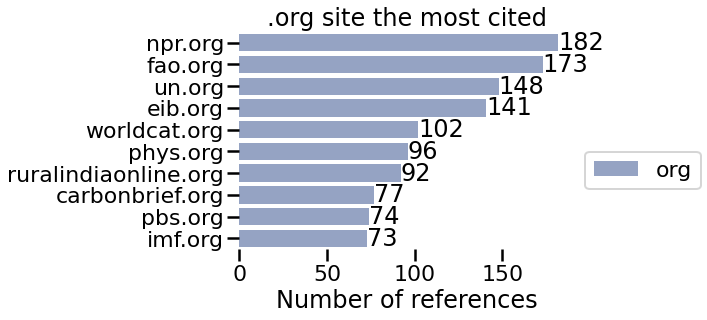

In [332]:
#An example of the plot for .org citation
dorg,dico=sortcitation(df.loc[:,"citationorgtext"],"org")    
plot_site_most_cited(dorg,10,".org site the most cited")

5497


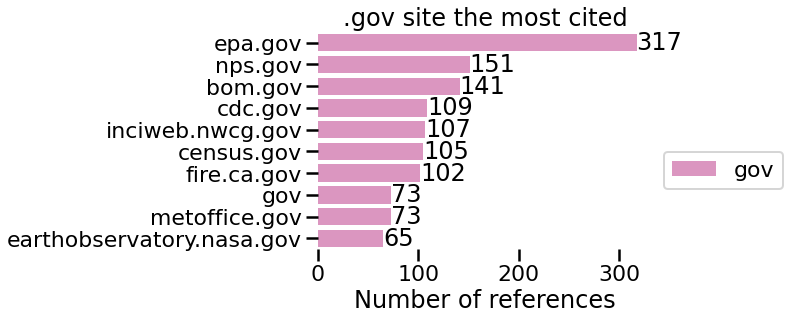

In [333]:
dfgov,j=sortcitation(df.loc[:,"citationgovtext"],"gov")
plot_site_most_cited(dfgov,10,".gov site the most cited")

test [['nature climate change '], ['science advances '], ['nature climate change '], ['climatic change '], ['the cryosphere'], ['environmental research letters '], ['energy and climate change'], ['environmental research letters', (' sea ice thickness', ' thickness', 'thickness', 'v')], ['climatic change'], ['environment and urbanization '], ['current climate change reports '], ['proceedings of the national academy of sciences'], ['nature communications'], ['[[science '], ['journal of hydrology '], ['proceedings of the national academy of sciences of the united states of america '], ['journal of hydrology '], ['american journal of public health '], ['springer international publishing'], ['nature'], ['climatic change ', 'kluwer academic publishers '], ['global change biology '], ['disaster prevention and management '], ['pnas '], ['climate research'], ['geophysical research letters'], ['science '], ['international journal of environmental research and public health '], ['nature climate c

test [['nóesis. revista de ciencias sociales y humanidades '], ['journal of economic literature '], ['routledge '], ['energy policy'], ['energy policy '], ['energy policy '], ['wiley interdisciplinary reviews'], ['journal of cleaner production '], ['world development '], ['atmospheric environment '], ['energy research '], ['energy policy '], ['international journal of environmental research and public health '], ['energy economics '], ['energy and buildings '], [(' social science', ' science', 'science', 'v')], ['oxford university press '], ['energy reports'], ['renewable and sustainable energy reviews '], ['renewable and sustainable energy reviews '], ['social '], ['energy ']]
test [['speculum'], ['proceedings of the national academy of sciences of the united states of america'], ['the medieval history journal '], ['economic history review '], ['the economic history review'], ['historische zeitschrift '], ['nature'], ['french history '], ['historische zeitschrift ', (' economic histor

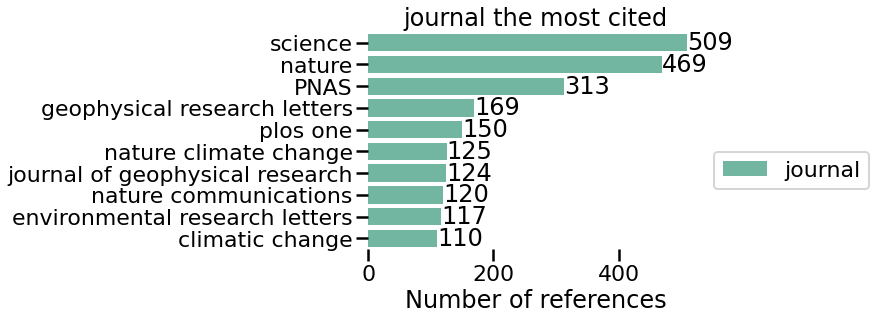

In [334]:
dfsci,j=sortcitation(df.loc[:,"journal"],"journal")
plot_site_most_cited(dfsci,10, "journal the most cited")

16959


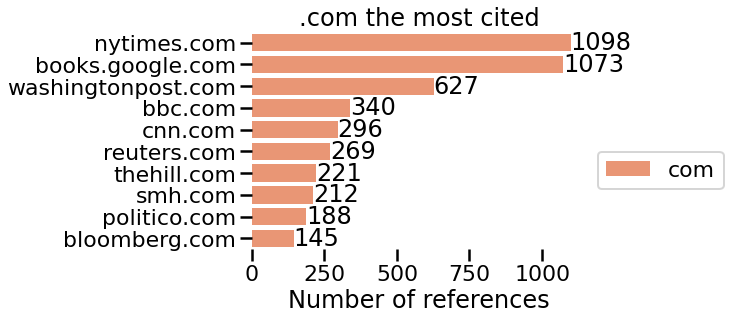

In [335]:
dcom,bl=sortcitation(df.loc[:,"citationcomtext"],"com")
plot_site_most_cited(dcom,10, ".com the most cited")

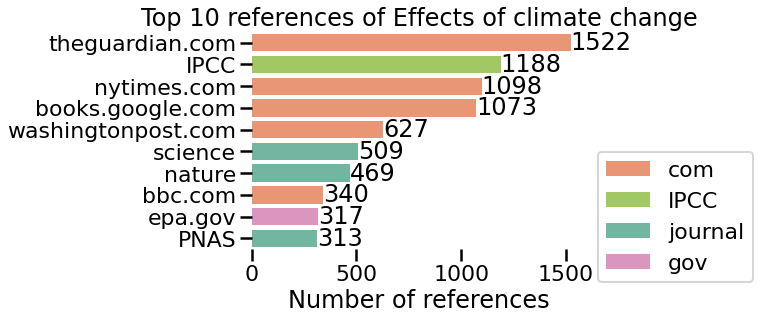

In [336]:
dIg={"name of site": ["IPCC","theguardian.com"], "number of times cited":[df.loc[:,"citation IPCC"].sum(), df.loc[:,"citationguardian"].sum()], "type": ["IPCC","com"]}
dIg = pd.DataFrame.from_dict(dIg)
big_df = pd.concat([dorg, dfgov,dcom,dfsci,dIg], ignore_index=True)
big_df.sort_values(by=['number of times cited'], inplace=True, ascending=False)
plot_site_most_cited(big_df,10,"Top 10 references of Effects of climate change")

## Cleaning the column and exporting the data frame and scrap of page information

In [337]:
titlelist=df["Name only"].tolist() #make a list will all titles
#We need to recreate the wiki url, first step is to get rid of blanks
titleunderscore = [sub.replace(' ', '_') for sub in titlelist]

In [338]:
#We finally get from the original url to the pageinfo url
urlmodifié = ['https://en.wikipedia.org/w/index.php?title=' + i +'&action=info' for i in titleunderscore]

In [339]:
#Cell to scrap infos from "page info" section (2 to scrap the third table of the page)
doblist=[]
creatorlist=[]
totaledits=[]
recentedits=[]
pageid=[]
pagelenght=[]
editprotection=[]
recentpageviews=[]

for i in tqdm(urlmodifié) :
    source = requests.get(i)
    soup = BeautifulSoup(source.text, 'lxml')
    alltables=soup.findAll('table', {"class": "wikitable mw-page-info"})
    tableau_html_liste=pd.read_html(str(alltables)) #We get it as a list   
    df_pageinfo2=pd.DataFrame(tableau_html_liste[2]) #And make it a df 
    #The number between brackets corresponds to the number of the table according to its order on the html page
    creatorlist += [df_pageinfo2.iat[0, 1]]
    doblist += [df_pageinfo2.iat[1, 1]]
    totaledits += [df_pageinfo2.iat[4, 1]]
    recentedits += [df_pageinfo2.iat[5, 1]]
    
    
    #Scrap of the first table of the page (0)
    df_pageinfo0=pd.DataFrame(tableau_html_liste[0])
    pagelenght += [df_pageinfo0.iat[2, 1]]
    pageid += [df_pageinfo0.iat[3, 1]]
            
    
    #Scrap of the second table of the page (1)
    df_pageinfo1=pd.DataFrame(tableau_html_liste[1])
    editprotection += [df_pageinfo1.iat[1, 1]]
  

    

100%|████████████████████████████████████████████████████████████████████████████████| 921/921 [11:26<00:00,  1.34it/s]


In [342]:
#Cell to add the new lists as new columns of the df
df["Page id"]=pageid
df["Edit protection"]=editprotection
df["Page lenght (Bytes)"]=pagelenght
df["DOB"]=doblist
df["Creator"]=creatorlist
df["Total edits"]=totaledits
df["Recent edits"]=recentedits
df.head()

,Name only,page url,text,citations,Ref count,nb_journal_citations,journalcitation,journal,nbjournaldetected,citation org,...,Sci count,IPCC count,percentage of official sources,Page id,Edit protection,Page lenght (Bytes),DOB,Creator,Total edits,Recent edits
0,Effects of climate change,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|Effects created by climate...,"{'Ref count': 252, 'journal_count': 56, 'nb_jo...",252,58,"[10.1038/s41558-019-0412-1, 10.1126/sciadv.aba...","[[nature climate change ], [science advances ]...",56,27,...,0.230159,0.376984,0.817460,2119174,Require autoconfirmed or confirmed access (no ...,186539,"15:09, 26 June 2005",Rd232 (talk | contribs),5538,17
1,Effects of climate change on agriculture,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|None}}\n{{about||contribut...,"{'Ref count': 142, 'journal_count': 49, 'nb_jo...",142,51,"[10.1016/s0169-5347(02)02587-9, 10.1007/s10584...","[[trends in ecology ], [climatic change], [sci...",49,19,...,0.359155,0.133803,0.647887,47512577,Allow all users (no expiry set),115616,"04:31, 13 August 2015",Jarble (talk | contribs),288,118
2,Effects of climate change on human health,https://en.wikipedia.org/wiki/Effects_of_clima...,[[File:Atlanta thermal.jpg|thumb|Illustration ...,"{'Ref count': 111, 'journal_count': 56, 'nb_jo...",111,56,"[10.1016/j.foreco.2009.09.002, 10.1111/j.1708-...","[[forest ecology and management ], [[[internat...",56,13,...,0.504505,0.072072,0.756757,37063005,Allow all users (no expiry set),91158,"18:13, 19 September 2012",Ppowers29 (talk | contribs),1117,23
3,Effects of climate change on oceans,https://en.wikipedia.org/wiki/Effects_of_clima...,{{Short description|Effects of climate change ...,"{'Ref count': 121, 'journal_count': 63, 'nb_jo...",121,66,"[10.1146/annurev-environ-012320-083019, 10.111...",[[annual review of environment and resources ]...,63,14,...,0.545455,0.074380,0.760331,35895879,Allow all users (no expiry set),97693,"23:46, 21 May 2012",Antblasko (talk | contribs),539,12
4,Effects of climate change on ecosystems,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|How increased greenhouse g...,"{'Ref count': 86, 'journal_count': 48, 'nb_jou...",86,49,"[10.1073/pnas.0502286102, 10.1111/j.1752-4571....",[[proceedings of the national academy of scien...,48,7,...,0.569767,0.058140,0.744186,26515241,Allow all users (no expiry set),59046,"15:56, 11 March 2010",Enescot (talk | contribs),399,27


In [343]:
#Cleaning the table

#Getting rid of the time
df["DOB"]= df["DOB"].str.slice(7,100,1) 
#peutêtre qu'on pourrait mettre comme end point la len de la string

#Format the date
df["Formated DOB"]=pd.to_datetime(df["DOB"], format='%d %B %Y')
df["Year_month"]= pd.to_datetime(df['DOB']).dt.to_period('M')

#Getting the year
df['Year'] = pd.DatetimeIndex(df['DOB']).year

#Cleaning the creator 
df["Creator"]= df["Creator"].str.replace(r"\(.*\)",'', regex=True)

In [344]:
df

,Name only,page url,text,citations,Ref count,nb_journal_citations,journalcitation,journal,nbjournaldetected,citation org,...,Page id,Edit protection,Page lenght (Bytes),DOB,Creator,Total edits,Recent edits,Formated DOB,Year_month,Year
0,Effects of climate change,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|Effects created by climate...,"{'Ref count': 252, 'journal_count': 56, 'nb_jo...",252,58,"[10.1038/s41558-019-0412-1, 10.1126/sciadv.aba...","[[nature climate change ], [science advances ]...",56,27,...,2119174,Require autoconfirmed or confirmed access (no ...,186539,26 June 2005,Rd232,5538,17,2005-06-26,2005-06,2005
1,Effects of climate change on agriculture,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|None}}\n{{about||contribut...,"{'Ref count': 142, 'journal_count': 49, 'nb_jo...",142,51,"[10.1016/s0169-5347(02)02587-9, 10.1007/s10584...","[[trends in ecology ], [climatic change], [sci...",49,19,...,47512577,Allow all users (no expiry set),115616,13 August 2015,Jarble,288,118,2015-08-13,2015-08,2015
2,Effects of climate change on human health,https://en.wikipedia.org/wiki/Effects_of_clima...,[[File:Atlanta thermal.jpg|thumb|Illustration ...,"{'Ref count': 111, 'journal_count': 56, 'nb_jo...",111,56,"[10.1016/j.foreco.2009.09.002, 10.1111/j.1708-...","[[forest ecology and management ], [[[internat...",56,13,...,37063005,Allow all users (no expiry set),91158,19 September 2012,Ppowers29,1117,23,2012-09-19,2012-09,2012
3,Effects of climate change on oceans,https://en.wikipedia.org/wiki/Effects_of_clima...,{{Short description|Effects of climate change ...,"{'Ref count': 121, 'journal_count': 63, 'nb_jo...",121,66,"[10.1146/annurev-environ-012320-083019, 10.111...",[[annual review of environment and resources ]...,63,14,...,35895879,Allow all users (no expiry set),97693,21 May 2012,Antblasko,539,12,2012-05-21,2012-05,2012
4,Effects of climate change on ecosystems,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|How increased greenhouse g...,"{'Ref count': 86, 'journal_count': 48, 'nb_jou...",86,49,"[10.1073/pnas.0502286102, 10.1111/j.1752-4571....",[[proceedings of the national academy of scien...,48,7,...,26515241,Allow all users (no expiry set),59046,11 March 2010,Enescot,399,27,2010-03-11,2010-03,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,Restore America's Estuaries,https://en.wikipedia.org/wiki/Restore_America%...,{{Infobox organization\n| name = Restore Ameri...,"{'Ref count': 18, 'journal_count': 0, 'nb_jour...",18,0,[],[],0,16,...,28084829,Allow all users (no expiry set),17089,19 July 2010,Dchensummer,30,0,2010-07-19,2010-07,2010
917,Carbon bubble,https://en.wikipedia.org/wiki/Carbon_bubble,{{Short description|Hypothesized bubble in the...,"{'Ref count': 56, 'journal_count': 2, 'nb_jour...",56,2,"[10.1038/517150a, 10.1038/nature14016, 2556727...","[[[[nature , [[macmillan publishers], [[[natu...",2,15,...,39383318,Allow all users (no expiry set),41211,14 May 2013,Dmtk,305,0,2013-05-14,2013-05,2013
918,The Hunting Hypothesis,https://en.wikipedia.org/wiki/The_Hunting_Hypo...,{{about|the book|the underlying anthropologica...,"{'Ref count': 12, 'journal_count': 0, 'nb_jour...",12,0,[],[],0,1,...,47256663,Allow all users (no expiry set),10537,16 July 2015,J579513,32,0,2015-07-16,2015-07,2015
919,David Quinn (columnist),https://en.wikipedia.org/wiki/David_Quinn_(col...,{{short description|Irish social and religious...,"{'Ref count': 29, 'journal_count': 0, 'nb_jour...",29,0,[],[],0,3,...,7772490,Allow all users (no expiry set),17472,4 November 2006,Fish720,265,1,2006-11-04,2006-11,2006


#### Plot the ratio of page created by a certain editor in our corpus

#### plot of the timeline

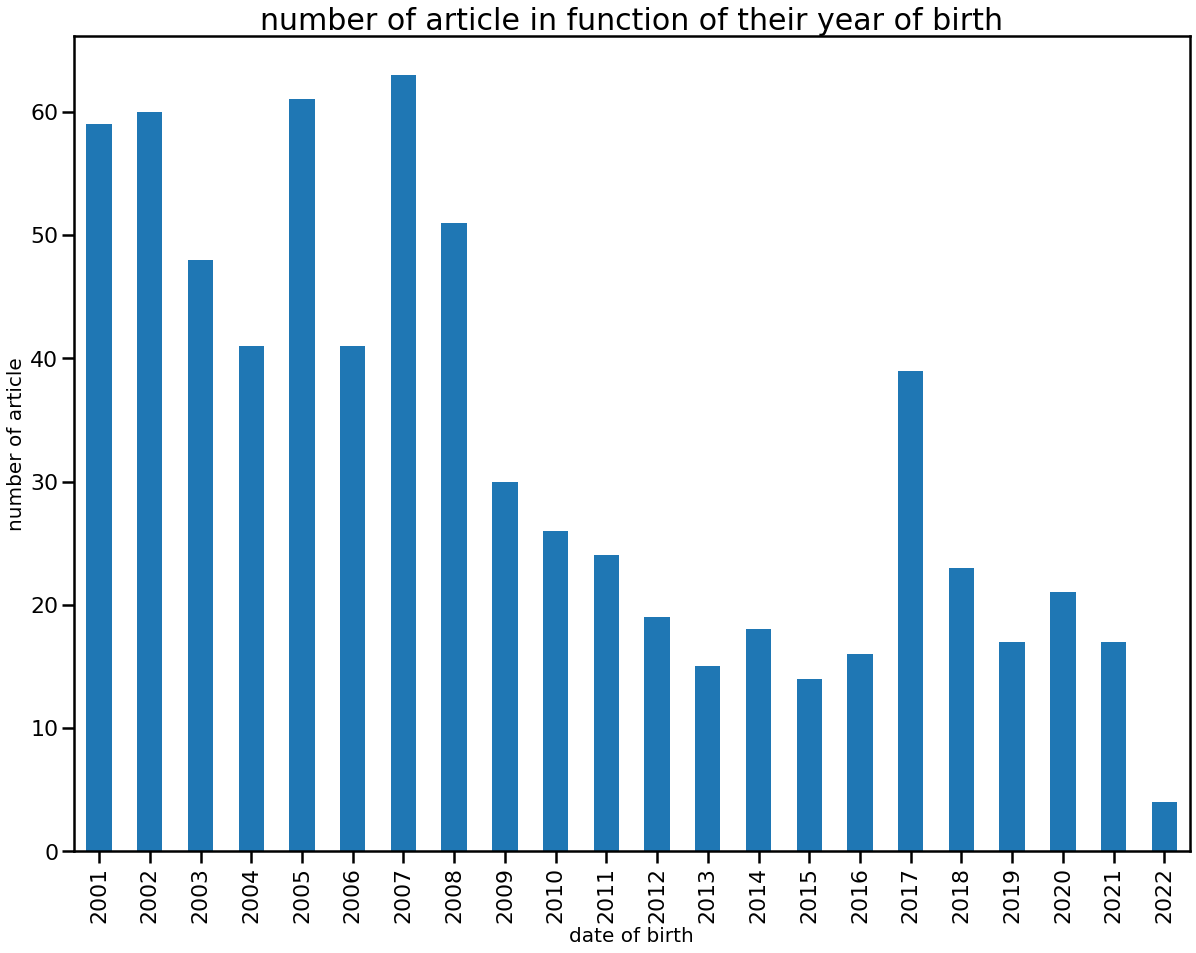

In [162]:
fig = plt.figure(0,figsize=(20,15))
plothist=df["Year"].value_counts().sort_index().plot(kind="bar")
fig.savefig('timeline.jpg', bbox_inches='tight', dpi=150)
plt.xlabel('date of birth',fontsize = 20) 
plt.ylabel('number of article',fontsize = 20) 
plt.title("number of article in function of their year of birth",fontsize = 30)
plt.show()

#### Clean and export the dataframes to csv

In [179]:
del df['citationorgtext']
del df['citationgovtext']
del df['text']
del df["citations"]
del df["citationcomtext"]

In [345]:
#extract the data frame to csv
df.to_csv('climatechange.csv')
'''
dorg.to_csv('CRISPR.csv')
dfgov.to_csv('CRISPR.csv')
dcom.to_csv('CRISPR.csv')'''

"\ndorg.to_csv('CRISPR.csv')\ndfgov.to_csv('CRISPR.csv')\ndcom.to_csv('CRISPR.csv')"